In [7]:
import os
import pyproj

# 自动设置 PROJ_LIB 环境变量
os.environ['PROJ_DATA'] = os.path.join(pyproj.datadir.get_data_dir(), 'proj')
# 或者更稳妥地直接设为包含 proj.db 的目录：
os.environ['PROJ_DATA'] = pyproj.datadir.get_data_dir()
print(os.environ['PROJ_DATA'],pyproj.__version__)

F:\JupyterProject\.venv\Lib\site-packages\pyproj\proj_dir\share\proj 3.7.2


#### 挑选时间切片

In [ ]:
# 1. 读取数据
df = pd.read_csv("whu_crowded//dataset//od_grid_six_month.csv")
# 筛选条件（默认按照O点筛选）
is_weekend = False
hour = 18
origin_condition = (df["is_weekend"] == is_weekend) & (df["origin_hour"] == hour)
# 应用筛选
filtered_df_origin = df[origin_condition]
# 查看结果
print(f"筛选到 {len(filtered_df_origin)} 条起点记录")

#### 统计OD语义去向——表格

In [ ]:
def analyze_od_semantics(df):
    """
    统计每个cluster_id的起点-终点语义对数量及占比（排除cluster_id = -1）
    
    参数:
        df (pd.DataFrame): 输入的DataFrame，需包含cluster_id, semantics_origin, semantics_dest字段
        
    返回:
        pd.DataFrame: 包含以下列的结果DataFrame:
            - cluster_id: 聚类ID（不包括-1）
            - semantics_origin: 起点语义
            - semantics_dest: 终点语义
            - count: 该语义对出现的次数
            - total_in_cluster: 该cluster_id的总记录数
            - percentage: 该语义对在该cluster_id中的占比(0-100)
    """
    # 检查必要字段是否存在
    required_columns = ['cluster_id', 'semantics_origin', 'semantics_dest']
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"DataFrame必须包含以下列: {required_columns}")
    
    # 排除cluster_id = -1的记录
    filtered_df = df[df['cluster_id'] != -1].copy()
    
    # 统计每个cluster_id的总记录数
    total_counts = filtered_df.groupby('cluster_id').size().reset_index(name='total_in_cluster')
    
    # 统计每个语义对的出现次数
    od_counts = (
        filtered_df.groupby(['cluster_id', 'semantics_origin', 'semantics_dest'])
        .size()
        .reset_index(name='count')
    )
    
    # 合并总记录数并计算占比
    result_df = od_counts.merge(total_counts, on='cluster_id')
    result_df['percentage'] = (result_df['count'] / result_df['total_in_cluster']) * 100
    
    # 按cluster_id和count降序排序
    result_df = result_df.sort_values(['cluster_id', 'count'], ascending=[True, False])
    
    return result_df.reset_index(drop=True)

In [ ]:
for is_workday in ["工作日", "非工作日"]:
    for hour in range(24):
        flow_data = pd.read_csv(f'./data/data/od_flow_cluster_{is_workday}_{hour}.csv') # 具体切片具体调整
        result = analyze_od_semantics(flow_data)
        # print(result.head())
        result.to_csv(f'./data/semantics-data/semantics_by_cluster_{is_workday}_{hour}.csv', index=False)

#### 可视化统计OD语义——semantics/category(双饼图)

In [ ]:
# ------------------------- 通用工具函数 -------------------------
def adjust_labels(text_objects):
    """智能调整标签位置防止重叠"""
    positions = np.array([t.get_position() for t in text_objects])
    angles = np.arctan2(positions[:,1], positions[:,0])
    
    for t, a in zip(text_objects, angles):
        # 自动旋转标签
        if a > np.pi/2 or a < -np.pi/2:
            t.set_rotation(np.degrees(a) + 90)
        else:
            t.set_rotation(np.degrees(a))
        t.set_horizontalalignment('center')
        t.set_verticalalignment('center')

# ------------------------- 饼图模块 -------------------------
def plot_category_pie(ax, data, analysis_type, cmap):
    """防重叠饼图（修复索引异常）"""
    category_col = f'category_{analysis_type}'
    counts = data[category_col].value_counts().sort_values(ascending=False)
    
    # 过滤小类别（<1%合并为其他）
    main_counts = counts[counts/len(data) >= 0.01]
    if len(main_counts) < len(counts):
        main_counts['其他'] = counts[counts/len(data) < 0.01].sum()
    colors = cmap(np.linspace(0, 1, len(main_counts)))
    
    # 绘制饼图
    wedges, texts, autotexts = ax.pie(
        main_counts,
        labels=main_counts.index.tolist(),
        autopct=lambda pct: f'{pct:.1f}%' if pct >= 3 else '',
        startangle=90,
        colors=colors,
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
        textprops={'fontsize': 14, 'color': 'darkblue'},
        rotatelabels=True,
        pctdistance=0.8
    )
    
    # 标签防重叠处理
    adjust_labels(texts + autotexts)
    ax.set_title(f"{analysis_type.capitalize()}分类分布", fontsize=12, pad=20)

# ------------------------- 主程序 -------------------------
def plot_combined_clusters_v1(flow_data, top_clusters=1):
    """完整可视化流程"""
    # 数据准备
    clean_data = flow_data[flow_data['cluster_id'] > -1].copy()
    weighted_counts = clean_data.groupby('cluster_id')['flow_num'].sum().sort_values(ascending=False)
    top_clusters = weighted_counts.head(top_clusters).index.tolist()
    
    # 全局样式设置（兼容所有版本）
    plt.rcParams.update({
        'font.family': 'SimHei',
        'axes.titlesize': 14,
        'figure.dpi': 150,
        'axes.edgecolor': '#D0D0D0',
        'axes.labelcolor': '#303030',
        'axes.grid': True,
        'grid.color': '#F0F0F0',
        'grid.linestyle': '--',
        'grid.alpha': 0.6
    })
    
    # 循环处理每个cluster
    for cluster_id in top_clusters:
        cluster_data = clean_data[clean_data['cluster_id'] == cluster_id]
        print(f"cluster_num:", cluster_data["flow_num"].sum())
        # ================= 双饼图 =================
        fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        plot_category_pie(ax1, cluster_data, 'origin', cm.get_cmap('tab20'))
        plot_category_pie(ax2, cluster_data, 'dest', cm.get_cmap('tab20'))
        fig1.suptitle(f'Cluster {cluster_id} - 分类分布分析', y=0.95, fontsize=16)
        plt.tight_layout()
        plt.show()

# ------------------------- 饼图模块 -------------------------
def plot_semantics_pie(ax, data, analysis_type, cmap):
    """专业级语义分布饼图"""
    semantics_col = f'semantics_{analysis_type}'  # 修改关键列名
    counts = data[semantics_col].value_counts().sort_values(ascending=False)
    
    # 过滤小类别（<1%合并为其他）
    main_counts = counts[counts/len(data) >= 0.01]
    if len(main_counts) < len(counts):
        main_counts['其他'] = counts[counts/len(data) < 0.01].sum()
    colors = cmap(np.linspace(0, 1, len(main_counts)))
    
    # 绘制饼图
    wedges, texts, autotexts = ax.pie(
        main_counts,
        labels=main_counts.index.tolist(),
        autopct=lambda pct: f'{pct:.1f}%' if pct >= 3 else '',
        startangle=90,
        colors=colors,
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
        textprops={'fontsize': 14, 'color': 'darkblue'},
        rotatelabels=True,
        pctdistance=0.8
    )
    
    # 标签防重叠处理
    adjust_labels(texts + autotexts)
    ax.set_title(f"Semantics {analysis_type.capitalize()} 分布",  # 修改标题
                fontsize=14, pad=80)

# ------------------------- 主程序 -------------------------
def plot_combined_clusters_v2(flow_data, top_clusters=1):
    """完整可视化流程（语义分析版）"""
    # 数据准备（新增语义字段校验）
    required_cols = {'semantics_origin', 'semantics_dest'}
    assert required_cols.issubset(flow_data.columns), "缺少语义分析字段"
    
    clean_data = flow_data[flow_data['cluster_id'] > -1].copy()
    weighted_counts = clean_data.groupby('cluster_id')['flow_num'].sum().sort_values(ascending=False)
    top_clusters = weighted_counts.head(top_clusters).index.tolist()
    
    # 循环处理每个cluster
    for cluster_id in top_clusters:
        cluster_data = clean_data[clean_data['cluster_id'] == cluster_id]
        
        # ================= 双饼图 =================
        fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        plot_semantics_pie(ax1, cluster_data, 'origin', cm.get_cmap('tab20'))  # 修改调用
        plot_semantics_pie(ax2, cluster_data, 'dest', cm.get_cmap('tab20'))
        fig1.suptitle(f'Cluster {cluster_id} - 语义分布分析',  # 修改主标题
                     y=0.95, fontsize=16)
        plt.tight_layout()
        plt.show()

#### 纯图

In [ ]:
# ------------------------- 通用工具函数 -------------------------
def adjust_labels(text_objects):
    """智能调整标签位置防止重叠"""
    positions = np.array([t.get_position() for t in text_objects])
    angles = np.arctan2(positions[:,1], positions[:,0])
    
    for t, a in zip(text_objects, angles):
        # 自动旋转标签
        if a > np.pi/2 or a < -np.pi/2:
            t.set_rotation(np.degrees(a) + 90)
        else:
            t.set_rotation(np.degrees(a))
        t.set_horizontalalignment('center')
        t.set_verticalalignment('center')

# ------------------------- 饼图模块 -------------------------
def plot_category_pie(ax, data, analysis_type, cmap):
    """防重叠饼图（不显示标签版本）"""
    category_col = f'category_{analysis_type}'
    counts = data.groupby(category_col)['flow_num'].sum().sort_values(ascending=False)
    
    # 过滤小类别（<1%合并为其他）
    total_weighted = data['flow_num'].sum()  # flow_num的总和
    main_counts = counts[counts / total_weighted >= 0.01]
    if len(main_counts) < len(counts):
        main_counts['其他'] = counts[counts / total_weighted < 0.01].sum()
    colors = cmap(np.linspace(0, 1, len(main_counts)))
    
    # 绘制饼图（不显示标签）
    wedges = ax.pie(
        main_counts,
        labels=None,  # 设置为None不显示标签
        autopct=lambda pct: f'{pct:.1f}%', # 设置为None不显示百分比
        startangle=90,
        colors=colors,
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
    )[0]
    
    ax.set_title(f"{analysis_type.capitalize()}分类分布", fontsize=12, pad=20)

# ------------------------- 主程序 -------------------------
def plot_combined_clusters_v1(flow_data, top_clusters=5):
    """完整可视化流程"""
    # 数据准备
    clean_data = flow_data[flow_data['cluster_id'] > -1].copy()
    weighted_counts = clean_data.groupby('cluster_id')['flow_num'].sum().sort_values(ascending=False)
    top_clusters = weighted_counts.head(top_clusters).index.tolist()
    
    # 全局样式设置（兼容所有版本）
    plt.rcParams.update({
        'font.family': 'SimHei',
        'axes.titlesize': 14,
        'figure.dpi': 150,
        'axes.edgecolor': '#D0D0D0',
        'axes.labelcolor': '#303030',
        'axes.grid': True,
        'grid.color': '#F0F0F0',
        'grid.linestyle': '--',
        'grid.alpha': 0.6
    })
    
    # 循环处理每个cluster
    for cluster_id in top_clusters:
        cluster_data = clean_data[clean_data['cluster_id'] == cluster_id]
        print(f"cluster_num:", cluster_data["flow_num"].sum())
        # ================= 双饼图 =================
        fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        plot_category_pie(ax1, cluster_data, 'origin', cm.get_cmap('tab20'))
        plot_category_pie(ax2, cluster_data, 'dest', cm.get_cmap('tab20'))
        fig1.suptitle(f'Cluster {cluster_id} - 分类分布分析', y=0.95, fontsize=16)
        plt.tight_layout()
        plt.show()

# ------------------------- 饼图模块 -------------------------
def plot_semantics_pie(ax, data, analysis_type, cmap):
    """专业级语义分布饼图（完全无标签）"""
    semantics_col = f'semantics_{analysis_type}'
    counts = data.groupby(semantics_col)['flow_num'].sum().sort_values(ascending=False)
    
    # 过滤小类别（<1%合并为其他）
    total_weighted = data['flow_num'].sum()  # flow_num的总和
    main_counts = counts[counts / total_weighted >= 0.01]
    if len(main_counts) < len(counts):
        main_counts['其他'] = counts[counts / total_weighted < 0.01].sum()
    colors = cmap(np.linspace(0, 1, len(main_counts)))
    
    # 绘制饼图（完全无标签）
    wedges = ax.pie(
        main_counts,
        labels=None,  # 不显示标签
        autopct=lambda pct: f'{pct:.1f}%', # 不显示百分比
        startangle=90,
        colors=colors,
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
    )[0]
    
    ax.set_title(f"Semantics {analysis_type.capitalize()} 分布", 
                fontsize=14, pad=20)

# ------------------------- 主程序 -------------------------
def plot_combined_clusters_v2(flow_data, top_clusters=5):
    """完整可视化流程（语义分析版）"""
    # 数据准备（新增语义字段校验）
    required_cols = {'semantics_origin', 'semantics_dest'}
    assert required_cols.issubset(flow_data.columns), "缺少语义分析字段"
    
    clean_data = flow_data[flow_data['cluster_id'] > -1].copy()
    weighted_counts = clean_data.groupby('cluster_id')['flow_num'].sum().sort_values(ascending=False)
    top_clusters = weighted_counts.head(top_clusters).index.tolist()
    
    # 循环处理每个cluster
    for cluster_id in top_clusters:
        cluster_data = clean_data[clean_data['cluster_id'] == cluster_id]
        
        # ================= 双饼图 =================
        fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        plot_semantics_pie(ax1, cluster_data, 'origin', cm.get_cmap('tab20'))  # 修改调用
        plot_semantics_pie(ax2, cluster_data, 'dest', cm.get_cmap('tab20'))
        fig1.suptitle(f'Cluster {cluster_id} - 语义分布分析',  # 修改主标题
                     y=0.95, fontsize=16)
        plt.tight_layout()
        plt.show()

In [ ]:
flow_data = pd.read_csv('./data/data/od_flow_cluster_工作日_18.csv') # 具体切片具体调整
A = flow_data["flow_num"].sum()
print(A)
plot_combined_clusters_v1(flow_data, top_clusters=5)
plot_combined_clusters_v2(flow_data, top_clusters=5)

#### 匹配渔网并可视化结果——单个流簇的绘制（示例数据）

In [ ]:
def plot_separate_cluster_flows(flow_data, fishnet_gdf, top_clusters=5, output_path="cluster_flows"):
    # 过滤无效的cluster_id
    clean_data = flow_data[flow_data['cluster_id'] > -1].copy()
    
    # 获取地理范围
    minx, miny, maxx, maxy = fishnet_gdf.total_bounds
    aspect_ratio = (maxy - miny) / (maxx - minx)  # 计算长宽比
    
    # 动态颜色映射
    unique_clusters = clean_data['cluster_id'].unique()
    base_colors = plt.cm.tab20.colors + plt.cm.tab20b.colors
    color_map = {cluster: base_colors[i%len(base_colors)] for i, cluster in enumerate(unique_clusters)}
    
    # 获取前top_clusters个簇
    cluster_flows = (
        clean_data.groupby('cluster_id')
        .size()
        .sort_values(ascending=False)
        .head(top_clusters)
        .reset_index(name='total_flow')
    )
    
    # 为每个簇生成独立图片
    for cluster_id, total_flow in cluster_flows[['cluster_id', 'total_flow']].values:
        # 创建独立画布
        fig = plt.figure(figsize=(12, 12*aspect_ratio), dpi=150, facecolor='none')
        ax = fig.add_axes([0.05, 0.05, 0.75, 0.9])  # 主图区域
        
        # 绘制底图
        fishnet_gdf.boundary.plot(ax=ax, linewidth=0.6, color='#40404088', zorder=2)
        
        # 获取当前簇数据
        cluster_df = clean_data[clean_data['cluster_id'] == cluster_id]
        
        # 聚合OD流量
        od_flows = (
            cluster_df.groupby(['origin_lon', 'origin_lat',
                                'destination_lon', 'destination_lat'])
            .size()
            .reset_index(name='flow')
        )
        
        if not od_flows.empty:
            line_color = to_rgba(color_map[cluster_id], 0.7)
            max_flow = od_flows['flow'].max()
            
            # 绘制流线
            for _, row in od_flows.iterrows():
                line_width = 0.5 + 3.0 * (row['flow']/max_flow)**0.5
                ax.add_line(Line2D(
                    [row.origin_lon, row.destination_lon],
                    [row.origin_lat, row.destination_lat],
                    linewidth=line_width,
                    color=line_color,
                    solid_capstyle='round',
                    zorder=3
                ))
        
        # 设置显示范围
        ax.set(xlim=(minx, maxx), ylim=(miny, maxy))
        ax.axis('off')
        ax.patch.set_alpha(0.0)
        
        # 添加统计信息面板
        info_ax = fig.add_axes([0.82, 0.3, 0.16, 0.4])  # 右侧信息区域
        info_ax.axis('off')
        info_text = (
            f"Cluster ID: {cluster_id}\n"
            f"Total Flow: {total_flow:,}\n"
            f"OD Pairs: {len(od_flows):,}\n"
            f"Max Flow: {od_flows['flow'].max():,}"
        )
        info_ax.text(0.1, 0.8, info_text, 
                    ha='left', va='top', 
                    fontsize=11, 
                    color=color_map[cluster_id],
                    linespacing=1.8)
        
        # 保存文件
        plt.savefig(f"{output_path}_cluster_{cluster_id}.png", 
                   bbox_inches='tight', 
                   pad_inches=0.1,
                   transparent=True)
        plt.show()
        plt.close()

In [ ]:
flow_data = pd.read_csv('./data/data/od_flow_cluster_工作日_18.csv')
fishnet_gdf = gpd.read_file('./data/fishnet_with_semantics_fix.geojson')
# 使用示例
plot_separate_cluster_flows(flow_data, 
                           fishnet_gdf, 
                           top_clusters=5,
                           output_path="./result_visual/")

#### 匹配渔网并可视化结果——整体流簇的绘制

In [ ]:
def plot_combined_cluster_flows(flow_data, fishnet_gdf, top_clusters=5, output_path="combined_cluster_flows"):
    # 过滤无效的cluster_id
    clean_data = flow_data[flow_data['cluster_id'] > -1].copy()
    
    # 获取地理范围
    minx, miny, maxx, maxy = fishnet_gdf.total_bounds
    aspect_ratio = (maxy - miny) / (maxx - minx)
    
    # 动态颜色映射
    unique_clusters = clean_data['cluster_id'].unique()
    base_colors = plt.cm.tab20.colors + plt.cm.tab20b.colors
    color_map = {cluster: base_colors[i%len(base_colors)] for i, cluster in enumerate(unique_clusters)}
    
    # 获取前top_clusters个簇及其流量信息
    cluster_flows = (
        clean_data.groupby('cluster_id')
        .size()
        .sort_values(ascending=False)
        .head(top_clusters)
        .reset_index(name='total_flow')
    )
    
    # 创建画布
    fig = plt.figure(figsize=(12, 12*aspect_ratio), dpi=300, facecolor='none')
    ax = fig.add_axes([0.05, 0.05, 0.75, 0.9])  # 主图区域
    
    # 绘制底图
    fishnet_gdf.boundary.plot(ax=ax, linewidth=0.6, color='#40404088', zorder=2)
    
    # 收集所有图例元素
    legend_elements = []
    
    # 按流量倒序绘制保证大流量在顶层
    for cluster_id, total_flow in cluster_flows.sort_values('total_flow', ascending=False).values:
        cluster_df = clean_data[clean_data['cluster_id'] == cluster_id]
        
        # 聚合OD流量
        od_flows = (
            cluster_df.groupby(['origin_lon', 'origin_lat',
                                'destination_lon', 'destination_lat'])
            .size()
            .reset_index(name='flow')
        )
        # + 3.0 * (row['flow']/max_flow)**0.5
        if not od_flows.empty:
            line_color = to_rgba(color_map[cluster_id], 0.7)
            max_flow = od_flows['flow'].max()
            
            # 绘制流线（按流量排序保证大流量在顶层）
            for _, row in od_flows.sort_values('flow').iterrows():
                line_width = 0.5 
                arrowprops_kwargs = {}
                arrowprops_kwargs["color"] = line_color
                arrowprops_kwargs["lw"] = line_width
                arrowprops_kwargs["arrowstyle"] = arrowprops_kwargs.get("arrowstyle", "-|>")
                ax.annotate('',
                    [row.destination_lon, row.destination_lat],
                    [row.origin_lon, row.origin_lat], 
                    arrowprops=arrowprops_kwargs
                )
            
            # 收集图例元素
            legend_elements.append(Line2D(
                [0], [0],
                color=line_color,
                lw=2,
                label=f'Cluster {cluster_id}\nTotal: {total_flow:,}\nODs: {len(od_flows):,}'
            ))
    
    # 设置显示范围
    ax.set(xlim=(minx, maxx), ylim=(miny, maxy))
    ax.axis('off')
    ax.patch.set_alpha(0.0)
    
    # 添加图例
    legend_ax = fig.add_axes([0.82, 0.1, 0.18, 0.8])
    legend_ax.axis('off')
    legend_ax.legend(
        handles=legend_elements,
        loc='upper left',
        title="Flow Clusters",
        frameon=False,
        fontsize=9,
        handlelength=1.5,
        labelspacing=1.2
    )
    
    # 保存文件
    plt.savefig(f"{output_path}.png", 
               bbox_inches='tight', 
               pad_inches=0.1,
               transparent=True)
    plt.close()

In [ ]:
def plot_combined_cluster_flows(flow_data, fishnet_gdf, top_clusters=5, output_path="combined_cluster_flows"):
    # 过滤无效的cluster_id
    clean_data = flow_data[flow_data['cluster_id'] > -1].copy()
    
    # 获取地理范围
    minx, miny, maxx, maxy = fishnet_gdf.total_bounds
    aspect_ratio = (maxy - miny) / (maxx - minx)
    
    # 使用指定的颜色列表
    specified_colors = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231']
    
    # 获取前top_clusters个簇及其流量信息
    cluster_flows = (
        clean_data.groupby('cluster_id')['flow_num']
        .sum()
        .sort_values(ascending=False)
        .head(top_clusters)
        .reset_index(name='total_flow')
    )
    
    # 创建颜色映射 - 每个cluster_id分配唯一的颜色
    color_map = {}
    used_colors = set()
    
    # 为每个cluster_id分配颜色，确保不重复
    for i, (_, row) in enumerate(cluster_flows.iterrows()):
        cluster_id = row['cluster_id']
        
        # 尝试从指定颜色中选择
        for color in specified_colors:
            if color not in used_colors:
                color_map[cluster_id] = color
                used_colors.add(color)
                break
        else:
            # 如果指定颜色都用完了，使用备用颜色
            base_colors = plt.cm.tab20.colors
            # 将matplotlib颜色转换为十六进制
            backup_color = to_hex(base_colors[i % len(base_colors)])
            color_map[cluster_id] = backup_color
            used_colors.add(backup_color)
    
    # 创建画布
    fig = plt.figure(figsize=(12, 12*aspect_ratio), dpi=300, facecolor='none')
    ax = fig.add_axes([0.05, 0.05, 0.75, 0.9])  # 主图区域
    
    # 绘制底图
    fishnet_gdf.boundary.plot(ax=ax, linewidth=0.6, color='#40404088', zorder=2)
    
    # 收集所有图例元素
    legend_elements = []
    
    # 按流量倒序绘制保证大流量在顶层
    for cluster_id, total_flow in cluster_flows.sort_values('total_flow', ascending=False).values:
        cluster_df = clean_data[clean_data['cluster_id'] == cluster_id]
        
        # 聚合OD流量
        od_flows = (
            cluster_df.groupby(['origin_lon', 'origin_lat',
                                'destination_lon', 'destination_lat'])
            .size()
            .reset_index(name='flow')
        )
        
        if not od_flows.empty:
            line_color = to_rgba(color_map[cluster_id], 0.7)
            max_flow = od_flows['flow'].max()
            
            # 绘制流线（按流量排序保证大流量在顶层）
            for _, row in od_flows.sort_values('flow').iterrows():
                line_width = 0.5 
                arrowprops_kwargs = {}
                arrowprops_kwargs["color"] = line_color
                arrowprops_kwargs["lw"] = line_width
                arrowprops_kwargs["arrowstyle"] = arrowprops_kwargs.get("arrowstyle", "-|>")
                ax.annotate('',
                    [row.destination_lon, row.destination_lat],
                    [row.origin_lon, row.origin_lat], 
                    arrowprops=arrowprops_kwargs
                )
            
            # 收集图例元素
            legend_elements.append(Line2D(
                [0], [0],
                color=line_color,
                lw=2,
                label=f'Cluster {cluster_id}\nTotal: {total_flow:,}\nODs: {len(od_flows):,}'
            ))
    
    # 设置显示范围
    ax.set(xlim=(minx, maxx), ylim=(miny, maxy))
    ax.axis('off')
    ax.patch.set_alpha(0.0)
    
    # 添加图例
    legend_ax = fig.add_axes([0.82, 0.1, 0.18, 0.8])
    legend_ax.axis('off')
    legend_ax.legend(
        handles=legend_elements,
        loc='upper left',
        title="Flow Clusters",
        frameon=False,
        fontsize=9,
        handlelength=1.5,
        labelspacing=1.2
    )
    
    # 保存文件
    plt.savefig(f"{output_path}.png", 
               bbox_inches='tight', 
               pad_inches=0.1,
               transparent=True)
    plt.close()

In [ ]:
# flow_data = pd.read_csv("data/processed-data/cluster-mode/od_flow_cluster_grid_工作日_18.csv")
# fishnet_gdf = pd
# plot_combined_cluster_flows(
#     flow_data= flow_data,
#     fishnet_gdf= fishnet_gdf,
#     top_clusters=5,
#     output_path="./result_visual/top5_clusters"
# )


In [8]:
from matplotlib.lines import Line2D
from matplotlib.patches import FancyArrowPatch
from matplotlib.colors import to_hex
import geopandas as gpd
import math
import contextily as ctx
from matplotlib.colors import to_rgba
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['SimSun']
plt.rcParams['axes.unicode_minus'] = False
def plot_combined_cluster_flows(flow_data, top_clusters=5, output_path="combined_cluster_flows", zoom=12):
    # 过滤无效的cluster_id
    clean_data = flow_data[flow_data['cluster_id']>-1].copy()
    minx = clean_data['origin_lon'].min()-0.001
    miny = clean_data['origin_lat'].min()-0.001
    maxx = clean_data['origin_lon'].max()+0.001
    maxy = clean_data['origin_lat'].max()+0.001

    # 扩展边界以确保包含所有点
    minx = min(minx, clean_data['destination_lon'].min())
    miny = min(miny, clean_data['destination_lat'].min())
    maxx = max(maxx, clean_data['destination_lon'].max())
    maxy = max(maxy, clean_data['destination_lat'].max())

    aspect_ratio = (maxy - miny) / (maxx - minx)

    def get_mode_or_unknown(series):
        """获取众数，如果众数有多个则取第一个，空系列返回Unknown"""
        modes = series.mode()
        return modes.iloc[0] if not modes.empty else 'Unknown'

    # 获取前top_clusters个簇及其流量信息
    cluster_flows = (
        clean_data.groupby('cluster_id')
        .agg({
            'flow_num': 'sum',
            'semantics_origin': lambda x: get_mode_or_unknown(x),
            'semantics_dest': lambda x: get_mode_or_unknown(x)
        })
        .rename(columns={'flow_num': 'total_flow', 'semantics_origin': 'main_origin', 'semantics_dest': 'main_dest'})
        .sort_values('total_flow', ascending=False)
        .head(top_clusters)
        .reset_index()
    )
    remaining_flows = clean_data[~clean_data['cluster_id'].isin(cluster_flows['cluster_id'])]

    # 创建颜色映射 - 每个cluster_id分配唯一的颜色
    color_map = {}

    # 使用matplotlib的tab20颜色方案，确保每个簇有唯一颜色
    base_colors = plt.cm.tab20.colors
    specified_colors = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231',
                        '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe',
                        '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000',
                        '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080']

    # 为每个cluster_id分配颜色
    for i, (_, row) in enumerate(cluster_flows.iterrows()):
        cluster_id = row['cluster_id']

        # 如果指定颜色够用，使用指定颜色
        if i < len(specified_colors):
            color_map[cluster_id] = specified_colors[i]
        else:
            # 如果指定颜色不够，使用tab20颜色
            color_idx = i % len(base_colors)
            color_map[cluster_id] = to_hex(base_colors[color_idx])

    # 创建画布
    width_cm = 14.64
    width_inch = width_cm / 2.54  # ≈ 5.76 inches
    height_inch = width_inch * 1 # 可根据需要调整高度比例
    fig = plt.figure(figsize=(width_inch, height_inch), dpi=300, facecolor='none')
    ax = fig.add_axes([0.05, 0.05, 0.75, 0.9])  # 主图区域

    # 设置显示范围
    ax.set(xlim=(minx, maxx), ylim=(miny, maxy))

    # 使用contextily添加在线底图，使用高分辨率
    try:
        # 增加zoom级别以提高分辨率
        ctx.add_basemap(ax, crs='epsg:4326', source=ctx.providers.CartoDB.Voyager, zoom=zoom, alpha=0.7)
    except Exception as e:
        print(f"无法加载底图: {e}")
        # 如果无法加载在线底图，则使用空白背景
        ax.set_facecolor('#f0f0f0')

    # 收集所有图例元素
    legend_elements = []

    # 按流量倒序绘制保证大流量在顶层
    for _, row in cluster_flows.sort_values('total_flow', ascending=False).iterrows():
        cluster_id = row['cluster_id']
        total_flow = row['total_flow']
        main_origin = row['main_origin']
        main_dest = row['main_dest']
        cluster_df = clean_data[clean_data['cluster_id'] == cluster_id]

        # 聚合OD流量
        od_flows = (
            cluster_df.groupby(['origin_lon', 'origin_lat',
                                'destination_lon', 'destination_lat'])
            .size()
            .reset_index(name='flow')
        )

        if not od_flows.empty:
            line_color = to_rgba(color_map[cluster_id], 0.5)

            # 绘制流线（按流量排序保证大流量在顶层）
            for _, row in od_flows.sort_values('flow').iterrows():
                ax.annotate('',
                    xy=(row.destination_lon, row.destination_lat),
                    xytext=(row.origin_lon, row.origin_lat),
                    arrowprops=dict(
                        arrowstyle='->',
                        color=line_color,
                        lw=0.8,
                        shrinkA=0,
                        shrinkB=0,
                        mutation_scale=8
                    ),
                    zorder=5
                )

            # 收集图例元素
            legend_elements.append(FancyArrowPatch(
                (0, 0), (1, 0),  # 起点和终点
                color=line_color,
                arrowstyle='->',
                mutation_scale=1,  # 箭头大小
                lw=0.5,
                label=f'流簇主要起点终点语义 {main_origin}->{main_dest}流量: {total_flow}'
            ))

    # 绘制剩余流线（包括噪声）不显示
    if not remaining_flows.empty:
        od_flows_remaining = (
            remaining_flows.groupby(['origin_lon', 'origin_lat',
                                     'destination_lon', 'destination_lat'])
            .size()
            .reset_index(name='flow')
        )
        if not od_flows_remaining.empty:
            grey_color = to_rgba('grey', 0) # 使用半透明的灰色

            # 绘制剩余流线
            for _, row in od_flows_remaining.iterrows():
                ax.annotate('',
                    xy=(row.destination_lon, row.destination_lat),
                    xytext=(row.origin_lon, row.origin_lat),
                    arrowprops=dict(
                        arrowstyle='-|>',
                        color=grey_color,
                        lw=0.8,
                        shrinkA=0,
                        shrinkB=0,
                        mutation_scale=8
                    ),
                    zorder=2
                )
    if legend_elements:
        ax.legend(handles=legend_elements,
                 loc='lower center',
                 bbox_to_anchor=(0.5, -0.25),
                 fontsize=10)
    ax.axis('off')
    ax.patch.set_alpha(0.0)
    # 保存文件
    plt.savefig(f"{output_path}.png",
               bbox_inches='tight',
               pad_inches=0.1,
               transparent=True,
               dpi=300)
    plt.show()
    plt.close()

In [ ]:
flow_data = pd.read_csv("data/processed-data/cluster-mode/od_flow_cluster_grid_工作日_18.csv")
unique_count = flow_data['cluster_id'].nunique()
plot_combined_cluster_flows(flow_data, top_clusters=5, output_path="combined_cluster_flows",zoom=16)

In [39]:
from matplotlib.lines import Line2D
from matplotlib.patches import FancyArrowPatch
from matplotlib.legend_handler import HandlerPatch
from matplotlib.colors import to_hex
import geopandas as gpd
import math
import contextily as ctx
from matplotlib.colors import to_rgba
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['SimSun']
plt.rcParams['axes.unicode_minus'] = False

# 自定义图例处理器：绘制一个带箭头的短线
class HandlerArrow(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # 使用 get_edgecolor() 获取箭头颜色
        edgecolor = orig_handle.get_edgecolor()
        p = FancyArrowPatch(
            (0, 0.5 * height), (width, 0.5 * height),
            arrowstyle='-|>',
            mutation_scale=8,
            lw=2,
            edgecolor=edgecolor,
            facecolor='none',         
            transform=trans,
            clip_on=False
        )
        return [p]

def plot_combined_cluster_flows(flow_data, top_clusters=5, output_path="combined_cluster_flows", zoom=15):  # 建议 zoom ≥14
    # === 以下完全保留你的原始数据处理逻辑 ===
    clean_data = flow_data[flow_data['cluster_id'] > -1].copy()
    minx = clean_data['origin_lon'].min() - 0.001
    miny = clean_data['origin_lat'].min() - 0.001
    maxx = clean_data['origin_lon'].max() + 0.001
    maxy = clean_data['origin_lat'].max() + 0.001

    minx = min(minx, clean_data['destination_lon'].min())
    miny = min(miny, clean_data['destination_lat'].min())
    maxx = max(maxx, clean_data['destination_lon'].max())
    maxy = max(maxy, clean_data['destination_lat'].max())

    aspect_ratio = (maxy - miny) / (maxx - minx)

    def get_mode_or_unknown(series):
        modes = series.mode()
        return modes.iloc[0] if not modes.empty else 'Unknown'

    cluster_flows = (
        clean_data.groupby('cluster_id')
        .agg({
            'flow_num': 'sum',
            'semantics_origin': lambda x: get_mode_or_unknown(x),
            'semantics_dest': lambda x: get_mode_or_unknown(x)
        })
        .rename(columns={'flow_num': 'total_flow', 'semantics_origin': 'main_origin', 'semantics_dest': 'main_dest'})
        .sort_values('total_flow', ascending=False)
        .head(top_clusters)
        .reset_index()
    )
    remaining_flows = clean_data[~clean_data['cluster_id'].isin(cluster_flows['cluster_id'])]

    color_map = {}
    base_colors = plt.cm.tab20.colors
    specified_colors = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231',
                        '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe',
                        '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000',
                        '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080']

    for i, (_, row) in enumerate(cluster_flows.iterrows()):
        cluster_id = row['cluster_id']
        if i < len(specified_colors):
            color_map[cluster_id] = specified_colors[i]
        else:
            color_idx = i % len(base_colors)
            color_map[cluster_id] = to_hex(base_colors[color_idx])
    # === 以上完全保留你的原始逻辑 ===

    # 创建画布（保留你的尺寸设置）
    width_cm = 14.64
    width_inch = width_cm / 2.54
    height_inch = width_inch * 1
    fig = plt.figure(figsize=(width_inch, height_inch), dpi=300, facecolor='none')
    ax = fig.add_axes([0.05, 0.05, 0.75, 0.9])

    # === 关键修正 1：底图投影处理 ===
    # 先将边界转为 Web Mercator (EPSG:3857)，因为在线瓦片基于此投影
    import pyproj
    transformer = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
    minx_m, miny_m = transformer.transform(minx, miny)
    maxx_m, maxy_m = transformer.transform(maxx, maxy)

    ax.set_xlim(minx_m, maxx_m)
    ax.set_ylim(miny_m, maxy_m)

    try:
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager, zoom=zoom, alpha=0.7)
    except Exception as e:
        print(f"无法加载底图: {e}")
        ax.set_facecolor('#f0f0f0')

    # === 辅助函数：将经纬度点转为 Web Mercator 用于绘图 ===
    def lonlat_to_merc(lon, lat):
        return transformer.transform(lon, lat)

    legend_elements = []

    # === 绘制主要簇（保留你的循环结构，仅坐标转换）===
    for _, row in cluster_flows.sort_values('total_flow', ascending=False).iterrows():
        cluster_id = row['cluster_id']
        total_flow = row['total_flow']
        main_origin = row['main_origin']
        main_dest = row['main_dest']
        cluster_df = clean_data[clean_data['cluster_id'] == cluster_id]

        od_flows = (
            cluster_df.groupby(['origin_lon', 'origin_lat',
                                'destination_lon', 'destination_lat'])
            .size()
            .reset_index(name='flow')
        )

        if not od_flows.empty:
            line_color = to_rgba(color_map[cluster_id], 0.5)

            for _, r in od_flows.sort_values('flow').iterrows():
                ox_m, oy_m = lonlat_to_merc(r.origin_lon, r.origin_lat)
                dx_m, dy_m = lonlat_to_merc(r.destination_lon, r.destination_lat)
                ax.annotate('',
                    xy=(dx_m, dy_m),
                    xytext=(ox_m, oy_m),
                    arrowprops=dict(
                        arrowstyle='->',
                        color=line_color,
                        lw=0.8,
                        shrinkA=0,
                        shrinkB=0,
                        mutation_scale=8
                    ),
                    zorder=5
                )

            proxy_arrow = FancyArrowPatch(
                (0, 0), (1, 0),
                color=color_map[cluster_id],
                arrowstyle='->',
                lw=2,
                label=f'|流向语义:{main_origin} → {main_dest}|流量:{total_flow}条|'
            )
            legend_elements.append(proxy_arrow)

    # === 绘制剩余流线（同样做坐标转换）===
    if not remaining_flows.empty:
        od_flows_remaining = (
            remaining_flows.groupby(['origin_lon', 'origin_lat',
                                     'destination_lon', 'destination_lat'])
            .size()
            .reset_index(name='flow')
        )
        if not od_flows_remaining.empty:
            grey_color = to_rgba('grey', 0)  # 改为可见的浅灰色（原为透明）

            for _, r in od_flows_remaining.iterrows():
                ox_m, oy_m = lonlat_to_merc(r.origin_lon, r.origin_lat)
                dx_m, dy_m = lonlat_to_merc(r.destination_lon, r.destination_lat)
                ax.annotate('',
                    xy=(dx_m, dy_m),
                    xytext=(ox_m, oy_m),
                    arrowprops=dict(
                        arrowstyle='->',
                        color=grey_color,
                        lw=0.5,
                        shrinkA=0,
                        shrinkB=0,
                        mutation_scale=6
                    ),
                    zorder=2
                )

    # === 关键修正 3：图例表格式布局 ===
    if legend_elements:
        ax.legend(
            handles=legend_elements,
            loc='lower center',
            bbox_to_anchor=(0.5, -0.25),
            fontsize=10,
            ncol=2,
            columnspacing=1.2,
            handletextpad=0.6,
            frameon=False,
            handler_map={FancyArrowPatch: HandlerArrow()}
        )

    ax.axis('off')
    ax.patch.set_alpha(0.0)

    plt.savefig(f"{output_path}.png",
               bbox_inches='tight',
               pad_inches=0.1,
               transparent=True,
               dpi=300)
    plt.show()
    plt.close()

In [ ]:
flow_data = pd.read_csv("data/processed-data/cluster-mode/od_flow_cluster_grid_工作日_18.csv")
unique_count = flow_data['cluster_id'].nunique()
plot_combined_cluster_flows(flow_data, top_clusters=5, output_path="combined_cluster_flows",zoom=14)

无法加载底图: HTTPSConnectionPool(host='a.basemaps.cartocdn.com', port=443): Max retries exceeded with url: /rastertiles/voyager/14/13397/6730.png (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1028)')))


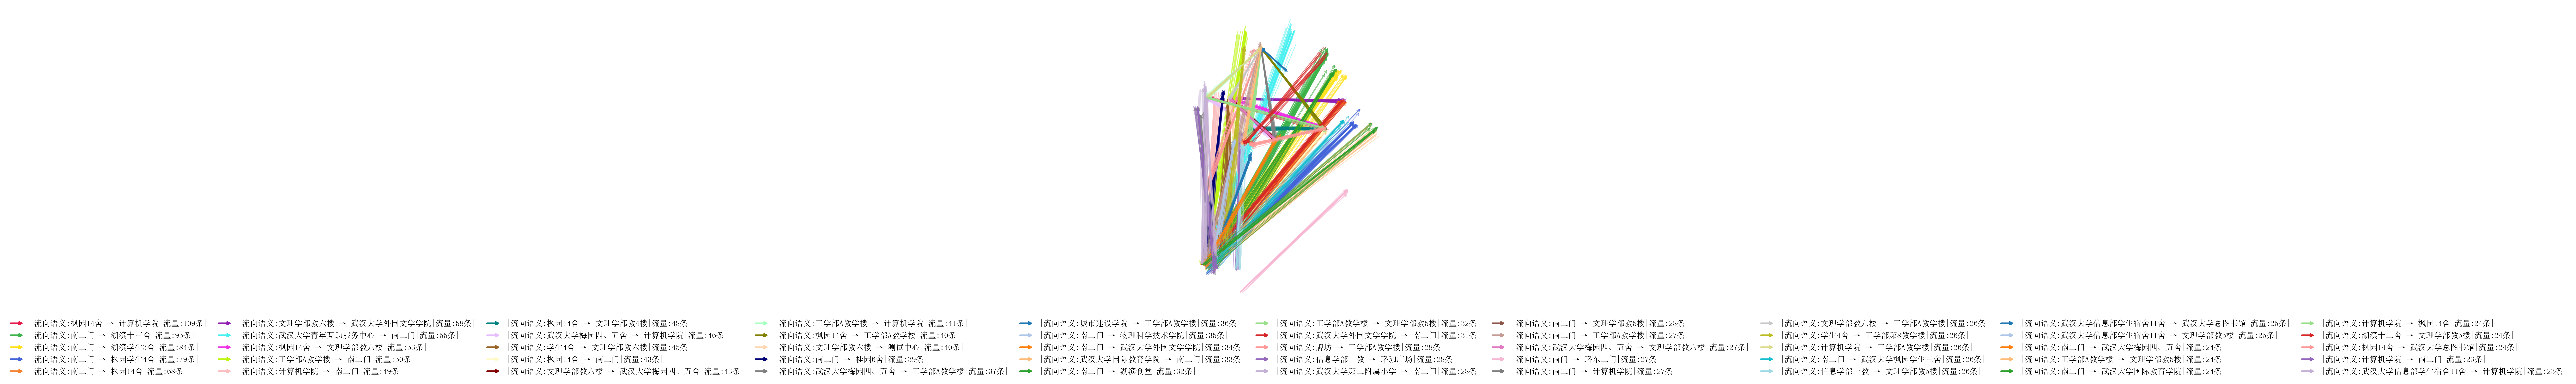

In [37]:
flow_data = pd.read_csv("data/processed-data/cluster-mode/od_flow_cluster_grid_工作日_18.csv")
unique_count = flow_data['cluster_id'].nunique()
plot_combined_cluster_flows(flow_data, top_clusters=50, output_path="combined_cluster_flows",zoom=14)

#### test


In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point, LineString
from shapely.validation import make_valid
import contextily as ctx
import warnings
warnings.filterwarnings('ignore')

# 1. 读取GeoJSON网格数据并修复无效几何图形
geojson_path = "data/fishnet_with_semantics_fix.geojson"
try:
    grid_gdf = gpd.read_file(geojson_path)
    print("GeoJSON网格数据读取成功！")
    print(f"网格包含 {len(grid_gdf)} 个要素")

    # 修复无效的几何图形
    grid_gdf['geometry'] = grid_gdf['geometry'].apply(
        lambda geom: make_valid(geom) if not geom.is_valid else geom
    )
    print("已修复无效几何图形")

except Exception as e:
    print(f"读取GeoJSON文件时出错: {e}")
    exit()

# 2. 读取OD流数据
od_csv_path = "data/processed-data/cluster-mode/od_flow_cluster_grid_工作日_18.csv"
try:
    od_df = pd.read_csv(od_csv_path)
    print("OD流数据读取成功！")
    print(f"数据包含 {len(od_df)} 条流记录")
except Exception as e:
    print(f"读取CSV文件时出错: {e}")
    exit()

# 3. 过滤掉cluster_id=-1的流
od_df = od_df[od_df['cluster_id'] != -1]
print(f"过滤后剩余 {len(od_df)} 条流记录")

# 4. 计算每个网格的中心点
grid_centroids = {}
for idx, row in grid_gdf.iterrows():
    try:
        # 尝试不同的ID字段名称
        grid_id = row.get('grid_id', row.get('id', idx))
        centroid = row.geometry.centroid
        if centroid.is_valid:
            grid_centroids[grid_id] = centroid
    except:
        continue

print(f"成功计算 {len(grid_centroids)} 个网格中心点")

# 5. 为OD流数据创建LineString几何图形
print("创建OD流线几何图形...")
od_lines = []

for _, row in od_df.iterrows():
    origin_id = row['origin_id']
    dest_id = row['destination_id']

    if origin_id in grid_centroids and dest_id in grid_centroids:
        origin_geom = grid_centroids[origin_id]
        dest_geom = grid_centroids[dest_id]

        # 创建LineString
        line = LineString([origin_geom, dest_geom])
        od_lines.append({
            'geometry': line,
            'origin_id': origin_id,
            'dest_id': dest_id,
            'cluster_id': row['cluster_id']
        })

# 创建OD流的GeoDataFrame
od_gdf = gpd.GeoDataFrame(od_lines, crs=grid_gdf.crs)
print(f"成功创建 {len(od_gdf)} 条OD流线")

# 6. 创建起点和终点的GeoDataFrame
print("创建起点和终点几何图形...")
origin_points = []
dest_points = []

for _, row in od_df.iterrows():
    origin_id = row['origin_id']
    dest_id = row['destination_id']

    if origin_id in grid_centroids:
        origin_points.append(grid_centroids[origin_id])
    if dest_id in grid_centroids:
        dest_points.append(grid_centroids[dest_id])

# 创建起点和终点的GeoDataFrame
origin_gdf = gpd.GeoDataFrame(geometry=origin_points, crs=grid_gdf.crs)
dest_gdf = gpd.GeoDataFrame(geometry=dest_points, crs=grid_gdf.crs)

print(f"起点数量: {len(origin_gdf)}")
print(f"终点数量: {len(dest_gdf)}")

# 7. 转换为Web墨卡托投影（用于底图）
grid_gdf = grid_gdf.to_crs(epsg=3857)
od_gdf = od_gdf.to_crs(epsg=3857)
origin_gdf = origin_gdf.to_crs(epsg=3857)
dest_gdf = dest_gdf.to_crs(epsg=3857)

# 8. 创建图形
fig, ax = plt.subplots(figsize=(15, 12))

# 9. 绘制GeoJSON网格（面数据）
grid_gdf.plot(ax=ax, facecolor='none', edgecolor='lightgray', linewidth=0.3, alpha=0.7)

# 10. 绘制OD流线
od_gdf.plot(ax=ax, color='blue', alpha=0.03, linewidth=0.5)

# 11. 绘制起点和终点
origin_gdf.plot(ax=ax, color='green', markersize=15, alpha=0.7, label='起点', edgecolor='white', linewidth=0.5)
dest_gdf.plot(ax=ax, color='red', markersize=15, alpha=0.7, label='终点', edgecolor='white', linewidth=0.5)

# 12. 添加底图
ctx.add_basemap(ax, source=ctx.providers.CartoDB.DarkMatter)

# 13. 设置图形属性
ax.set_title('OD流可视化 - 非工作日 18点\n(使用GeoPandas绘制)', fontsize=16, pad=20, color='white')
ax.set_axis_off()

# 14. 添加图例
legend = ax.legend()
for text in legend.get_texts():
    text.set_color('white')

# 15. 添加统计信息文本框
stats_text = f"""统计信息:
• 总流线数: {len(od_gdf)}
• 起点网格数: {len(set(od_df['origin_id']))}
• 终点网格数: {len(set(od_df['destination_id']))}
• 流线透明度: 0.03
• 排除cluster_id=-1的流"""
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='black', alpha=0.7),
        color='white')

plt.tight_layout()

# 16. 保存图形
try:
    plt.savefig('od_flow_geopandas_visualization_dark.png', dpi=300, bbox_inches='tight',
                facecolor='#2e2e2e', edgecolor='none')
    print("图形已保存为 'od_flow_geopandas_visualization_dark.png'")
except Exception as e:
    print(f"保存图形时出错: {e}")

plt.show()

# 17. 显示统计信息
print("\n=== 统计信息 ===")
print(f"总流线数量: {len(od_gdf)}")
print(f"唯一起点网格数量: {len(set(od_df['origin_id']))}")
print(f"唯一终点网格数量: {len(set(od_df['destination_id']))}")

# 显示流量的前10个起点和终点
origin_counts = od_df['origin_id'].value_counts().head(10)
dest_counts = od_df['destination_id'].value_counts().head(10)

print("\n流量最大的前10个起点:")
print(origin_counts)
print("\n流量最大的前10个终点:")
print(dest_counts)

#### 预处理

In [ ]:
for is_workday in ["工作日","非工作日"]:
    for hour in range(24):  
        print(f"正在处理{is_workday} {hour}时的数据")
        df = pd.read_csv(f"./data/data/od_flow_cluster_{is_workday}_{hour}.csv")
        unique_flow_num,counts = np.unique(df['cluster_id'], return_counts=True)
        frequency_distribution = pd.DataFrame({'cluster_id': unique_flow_num, 'count': counts})
        print(frequency_distribution)

In [ ]:
total_flow_num = 0
total_slice_flow_num = 0
for is_workday in ["工作日","非工作日"]:
    for hour in range(24):  
        df = pd.read_csv(f"./data/processed-data/cluster-mode/od_flow_cluster_grid_{is_workday}_{hour}.csv")
        slice_flow_num = df['flow_num'].sum()
        df = df[df['cluster_id'] > -1].copy() 
        flow_num = df['flow_num'].sum()
        total_flow_num += flow_num
        total_slice_flow_num += slice_flow_num
print("聚类总流量:", total_flow_num)        
print("切片总流量:", total_slice_flow_num)
print(f"覆盖率: {total_flow_num/total_slice_flow_num*100:.2f}%")

In [ ]:
import pandas as pd
import os

# 初始化一个空的DataFrame来存储所有数据
all_data = pd.DataFrame()
total_flow_num = 0
total_slice_flow_num = 0
for is_workday in ["工作日", "非工作日"]:
    for hour in range(24):
        file_path = f"./data/processed-data/cluster-mode/od_flow_cluster_grid_{is_workday}_{hour}.csv"
        
        # 检查文件是否存在
        if not os.path.exists(file_path):
            print(f"文件不存在: {file_path}")
            continue
            
        try:
            # 读取CSV文件
            df = pd.read_csv(file_path)
            slice_flow_num = df['flow_num'].sum()
            # 过滤cluster_id > -1的行
            df = df[df['cluster_id'] > -1].copy()
            flow_num = df['flow_num'].sum()
            total_flow_num += flow_num
            total_slice_flow_num += slice_flow_num
            # 选择需要保留的列
            columns_to_keep = [
                'order_id', 'bike_id', 'source', 'origin_lon', 'origin_lat', 'destination_lon', 'destination_lat', 'origin_time', 'destination_time',
                'is_workday', 'origin_hour', 'destination_hour', 'flow_num','flow_length',
                'cluster_id', 'origin_id', 'destination_id', 'semantics_origin',
                'semantics_dest', 'semantics_id_origin', 'semantics_id_dest',
                'category_origin', 'category_dest', 'category_id_origin', 'category_id_dest'
            ]
            
            # 确保所有需要的列都存在
            available_columns = [col for col in columns_to_keep if col in df.columns]
            df = df[available_columns]
            
            # 添加到总数据中
            all_data = pd.concat([all_data, df], ignore_index=True)
            
            print(f"已处理: {file_path}, 添加了 {len(df)} 行数据")
            
        except Exception as e:
            print(f"处理文件 {file_path} 时出错: {e}")

# 显示最终DataFrame的信息
print(f"\n总共合并了 {len(all_data)} 行数据")
print("数据列:", all_data.columns.tolist())
print("聚类总流量:", total_flow_num)        
print("切片总流量:", total_slice_flow_num)
print(f"覆盖率: {total_flow_num/total_slice_flow_num*100:.2f}%")
# 查看前几行数据
# print(all_data.head())
all_data.to_csv("./data/processed-data/cluster-mode/od_flow_cluster_grid_all.csv", index=False)

#### 流长频率分布分析

In [ ]:
df = pd.read_csv('./data/processed-data/cluster-mode/od_flow_cluster_grid_all_noise.csv')
df_without_noise = pd.read_csv('./data/processed-data/cluster-mode/od_flow_cluster_grid_all.csv')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.signal import find_peaks
import pandas as pd
df = pd.read_csv('./data/processed-data/cluster-mode/od_flow_cluster_grid_all.csv')
def plot_flow_histograms(df, gap, n_bins=30):
    """
    绘制flow_length的直方图
    """
    # 创建子图
    width_cm = 14.64
    width_inch = width_cm / 2.54  # ≈ 5.76 inches
    height_inch = width_inch * 1.5  # 可根据需要调整高度比例
    fig, ax = plt.subplots(figsize=(width_inch, height_inch))
    # 计算直方图数据
    n, bins, patches = ax.hist(df['flow_length'], bins=n_bins, color='steelblue', edgecolor='black', alpha=0.7)
    median_length = df['flow_length'].median()

    lower_percentile = 50 - gap / 2
    upper_percentile = 50 + gap / 2
    lower_bound = np.percentile(df['flow_length'], lower_percentile)
    upper_bound = np.percentile(df['flow_length'], upper_percentile)

    for i, (patch, bin_left, bin_right) in enumerate(zip(patches, bins[:-1], bins[1:])):
        if not (bin_right < lower_bound or bin_left > upper_bound):
            patch.set_facecolor('yellow')
            patch.set_alpha(0.8)

    ax.set_title('流长分布', fontsize=12, fontweight='bold')
    ax.set_xlabel('流长 （米）', fontsize=10)
    ax.set_ylabel('流量', fontsize=10)
    plt.xticks(fontproperties='Times New Roman', size=10)
    plt.yticks(fontproperties='Times New Roman', size=10)
    ax.grid(True, alpha=0.3)

    mean_length = df['flow_length'].mean()
    median_length = df['flow_length'].median()
    ax.axvline(mean_length, color='red', linestyle='--', linewidth=2, label=f'平均流长: {mean_length:.2f}米')
    ax.axvline(median_length, color='green', linestyle='--', linewidth=2, label=f'流长中位数: {median_length:.2f}米')

    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    coefficients = np.polyfit(bin_centers, n, 4)
    poly_line = np.polyval(coefficients, bin_centers)
    ax.plot(bin_centers, poly_line, 'r-', linewidth=2, label='数据拟合曲线')
    ax.axvspan(lower_bound, upper_bound, color='yellow', alpha=0.2, label=f'{gap}%分布区间')

    # 峰值检测与绘制
    peaks, properties = find_peaks(n, height=0, distance=15)
    peak_positions = (bins[:-1] + bins[1:])[peaks] / 2
    peak_lefts = bins[peaks]
    peak_rights = bins[peaks + 1]
    index = 0
    for peak in peak_positions:
        index += 1
        ax.axvline(x=peak, color='orange', linestyle='--', linewidth=2, label=f'第{index}峰值位于{peak:.2f}米')

    print(f"[{peak_lefts}, {peak_rights}]")
    ax.legend(bbox_to_anchor=(0.5, -1), loc='lower center', fontsize=10)
    ax.tick_params(axis='both', labelsize=8)
    plt.tight_layout()
    plt.savefig("流长分布图.png", dpi=300)
    plt.show()
def comprehensive_analysis(df, gap=90, n_bins=30):
    """
    综合分析函数：执行所有特征挖掘任务

    :param df: 包含flow_length列的DataFrame
    :param gap: 百分比区间参数
    :param n_bins: 直方图的bins数量
    """
    print("=== 流量分布直方图 ===")
    plot_flow_histograms(df, gap, n_bins)

comprehensive_analysis(df,60,50)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.signal import find_peaks
import pandas as pd

df = pd.read_csv('./data/processed-data/cluster-mode/od_flow_cluster_grid_all_noise.csv')

def plot_flow_histograms(df, gap, n_bins=30):
    """
    绘制flow_length的直方图
    """
    # 创建子图
    width_cm = 14.64
    width_inch = width_cm / 2.54  # ≈ 5.76 inches
    height_inch = width_inch * 0.8  # 可根据需要调整高度比例
    fig, ax = plt.subplots(figsize=(width_inch, height_inch))

    # 计算直方图数据
    n, bins, patches = ax.hist(df['flow_length'], bins=n_bins, color='steelblue', edgecolor='black', alpha=0.7)
    median_length = df['flow_length'].median()

    lower_percentile = 50 - gap / 2
    upper_percentile = 50 + gap / 2
    lower_bound = np.percentile(df['flow_length'], lower_percentile)
    upper_bound = np.percentile(df['flow_length'], upper_percentile)

    for i, (patch, bin_left, bin_right) in enumerate(zip(patches, bins[:-1], bins[1:])):
        if not (bin_right < lower_bound or bin_left > upper_bound):
            patch.set_facecolor('yellow')
            patch.set_alpha(0.8)

    ax.set_title('流长分布', fontsize=12, fontweight='bold')
    ax.set_xlabel('流长 （米）', fontsize=10)
    ax.set_ylabel('流量', fontsize=10)
    plt.xticks(fontproperties='Times New Roman', size=10)
    plt.yticks(fontproperties='Times New Roman', size=10)
    ax.grid(True, alpha=0.3)

    mean_length = df['flow_length'].mean()
    median_length = df['flow_length'].median()
    ax.axvline(mean_length, color='red', linestyle='--', linewidth=2, label=f'平均流长: {mean_length:.2f}米')
    ax.axvline(median_length, color='green', linestyle='--', linewidth=2, label=f'流长中位数: {median_length:.2f}米')

    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    coefficients = np.polyfit(bin_centers, n, 4)
    poly_line = np.polyval(coefficients, bin_centers)
    ax.plot(bin_centers, poly_line, 'r-', linewidth=2, label='数据拟合曲线')
    ax.axvspan(lower_bound, upper_bound, color='yellow', alpha=0.2, label=f'{gap}%分布区间')

    # 峰值检测与绘制
    peaks, properties = find_peaks(n, height=0, distance=15)
    peak_positions = (bins[:-1] + bins[1:])[peaks] / 2
    peak_lefts = bins[peaks]
    peak_rights = bins[peaks + 1]
    for i, peak in enumerate(peak_positions):
        ax.axvline(x=peak, color='orange', linestyle='--', linewidth=2, label=f'第{i+1}峰值位于{peak:.2f}米')

    print(f"[{peak_lefts}, {peak_rights}]")

    # 将图例放置在图表下方
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fontsize=10, ncol=2)
    ax.tick_params(axis='both', labelsize=8)

    # 调整布局以适应下方的图例
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    plt.savefig("流长分布图.png", dpi=300, bbox_inches='tight')
    plt.show()

def comprehensive_analysis(df, gap=90, n_bins=30):
    """
    综合分析函数：执行所有特征挖掘任务

    :param df: 包含flow_length列的DataFrame
    :param gap: 百分比区间参数
    :param n_bins: 直方图的bins数量
    """
    print("=== 流量分布直方图 ===")
    plot_flow_histograms(df, gap, n_bins)

comprehensive_analysis(df, 60, 50)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from typing import Dict, Tuple, Optional
from matplotlib.patches import Patch


def aggregate_small_percent_with_color(series, color_dict, threshold=0.05, other_label='其他'):
    """
    聚合小占比数据并返回值、标签和颜色列表

    参数说明：
    - series: pandas.Series，包含语义区域及其流量数值
    - color_dict: dict，语义区域到颜色的映射字典
    - threshold: float，占比小于该阈值的数据会被聚合为"其他"
    - other_label: str，聚合后的小占比数据的标签名称

    返回值：
    - values: list，聚合后的数值列表
    - labels: list，对应的标签列表
    - colors_list: list，对应的颜色列表
    """
    # 计算总流量，用于计算占比
    total = series.sum()
    # 计算每个语义区域的占比
    percentages = series / total
    # 创建掩码，标记占比大于等于阈值的数据
    large_mask = percentages >= threshold

    # 提取占比大的数据
    large_parts = series[large_mask]
    # 提取对应的标签
    labels = large_parts.index.tolist()
    # 提取对应的数值
    values = large_parts.values
    # 根据标签获取对应的颜色，如果找不到则使用默认灰色
    colors_list = [color_dict.get(lbl, (0.7, 0.7, 0.7, 1.0)) for lbl in labels]

    # 提取占比小的数据
    small_parts = series[~large_mask]
    # 如果存在小占比数据且总和大于0
    if len(small_parts) > 0 and small_parts.sum() > 0:
        # 将小占比数据聚合为一个数值
        values = np.append(values, small_parts.sum())
        # 添加"其他"标签
        labels = labels + [other_label]
        # 为"其他"分配灰色
        colors_list.append((0.7, 0.7, 0.7, 1.0))

    return values, labels, colors_list

def get_figure_dimensions():
    """
    获取图表尺寸参数

    返回值：
    - width_inch: float，图表宽度（英寸）
    - height_inch: float，图表高度（英寸）
    """
    # 定义图表宽度（厘米）
    width_cm = 14.64
    # 转换为英寸（1英寸=2.54厘米）
    width_inch = width_cm / 2.54  # ≈ 5.76 英寸
    # 设置高度为宽度的1.2倍（可调整）
    height_inch = width_inch * 1.2
    return width_inch, height_inch

def plot_double_donut(
        data_origin: pd.DataFrame,
        data_dest: pd.DataFrame,
        title_origin: str,
        title_dest: str,
        save_filename: str,
        semantic_to_color: Dict[str, str],
        threshold: float = 0.05,
        show_labels: bool = True
):
    """
    绘制双甜甜圈图（起点和终点分布）
    完全重构版本：通过嵌套plot_single_donut函数实现

    参数说明：
    - data_origin: DataFrame，起点数据
    - data_dest: DataFrame，终点数据
    - title_origin: str，起点图表标题
    - title_dest: str，终点图表标题
    - save_filename: str，保存文件名
    - semantic_to_color: dict，语义区域到颜色的映射
    - threshold: float，聚合小占比的阈值
    - show_labels: bool，是否显示标签
    """
    # 获取图表尺寸
    width_inch, height_inch = get_figure_dimensions()

    # 创建两个子图（一行两列）
    fig, axes = plt.subplots(1, 2, figsize=(width_inch, height_inch))

    # 定义一个内部函数，用于绘制单个甜甜圈图到指定的子图上
    def _plot_donut_to_axis(ax, data, title, groupby_col):
        """
        在指定的子图上绘制甜甜圈图

        参数：
        - ax: matplotlib.axes，子图对象
        - data: DataFrame，数据
        - title: str，图表标题
        - groupby_col: str，分组列名
        """
        if not data.empty:
            # 按指定列分组并求和流量数
            flow = data.groupby(groupby_col)['flow_num'].sum()
            if not flow.empty:
                # 聚合小占比数据并获取值、标签和颜色
                values, labels, colors_list = aggregate_small_percent_with_color(
                    flow, semantic_to_color, threshold=threshold, other_label='其他'
                )

                # 根据show_labels参数决定是否显示标签
                labels_param = labels if show_labels else None

                # 绘制甜甜圈图
                ax.pie(
                    values,
                    labels=labels_param,
                    autopct='%1.1f%%',
                    startangle=90,
                    colors=colors_list,
                    wedgeprops=dict(width=0.5),
                    textprops={'fontsize': 10},
                    labeldistance=1.05,
                    pctdistance=0.75
                )
            else:
                # 如果聚合后数据为空，显示相应提示
                ax.text(0.5, 0.5, f'无{title}数据', transform=ax.transAxes, ha='center', va='center')
        else:
            # 如果原始数据为空，显示"无数据"文本
            ax.text(
                0.5, 0.5, '无数据', transform=ax.transAxes, ha='center', va='center',
                fontsize=10, weight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray")
            )

        # 设置子图标题
        ax.text(0.5, 0, title,
        transform=ax.transAxes,
        fontsize=12,
        ha='center', va='top')
        return labels, colors_list

    # 左图：起点分布
    origin_labels, origin_colors = _plot_donut_to_axis(axes[0], data_origin, title_origin, 'semantics_origin')

    # 右图：终点分布
    dest_labels, dest_colors = _plot_donut_to_axis(axes[1], data_dest, title_dest, 'semantics_dest')

    def _get_unique_labels_and_colors(origin_labels, origin_colors, dest_labels, dest_colors):
        all_labels = (origin_labels or []) + (dest_labels or [])
        all_colors = (origin_colors or []) + (dest_colors or [])

        # 使用字典保持插入顺序
        unique_dict = dict(zip(all_labels, all_colors))

        # 提取键值对并排序，"其他"放在最后
        items = sorted(unique_dict.items(), key=lambda x: x[0] == "其他")

        labels = [item[0] for item in items]
        colors = [item[1] for item in items]

        return labels, colors

    final_labels, final_colors = _get_unique_labels_and_colors(origin_labels, origin_colors, dest_labels, dest_colors)

    fig.legend(
        handles=[Patch(color=color) for color in final_colors],
        labels=final_labels,
        loc="lower center",
        bbox_to_anchor=(0.5, 0.12),
        fontsize=10,
        ncol=2  # 分两列显示
    )

    # 调整布局
    plt.tight_layout()
    # 保存图片
    plt.savefig(save_filename, dpi=300, bbox_inches='tight')
    # 显示图形
    plt.show()

def create_semantic_color_mapping(df):
    """
    创建语义区域到颜色的映射

    参数说明：
    - df: DataFrame，包含语义区域信息

    返回值：
    - semantic_to_color: dict，语义区域到颜色的映射
    - all_semantics: list，所有唯一语义区域的排序列表
    """
    # 构建所有唯一语义区域的集合（起点和终点）
    all_semantics = set()
    all_semantics.update(df['semantics_origin'].unique())  # 添加起点语义区域
    all_semantics.update(df['semantics_dest'].unique())    # 添加终点语义区域

    # 转为排序列表（保证顺序一致）
    all_semantics = sorted(all_semantics)

    # 使用tab20颜色映射创建颜色
    cmap = plt.cm.tab20
    colors = cmap(np.linspace(0, 1, 20))  # tab20只有20种颜色
    color_cycle = cycle(colors)

    # 如果语义区域超过20个，循环使用颜色
    semantic_to_color = {}
    for i, semantic in enumerate(all_semantics):
        if i < 20:
            # 如果语义区域数量在20以内，直接分配颜色
            semantic_to_color[semantic] = colors[i]
        else:
            # 超过20个时循环使用颜色
            semantic_to_color[semantic] = colors[i % 20]

    return semantic_to_color, all_semantics

# 设置中文字体（解决中文显示问题）
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体显示中文
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

# 读取CSV文件
df = pd.read_csv("data/processed-data/cluster-mode/od_flow_cluster_grid_all.csv")

# 筛选指定flow_length区间的数据（728.82174971到770.6328629）
data_730_760 = df[(df['flow_length'] >= 728.82174971) & (df['flow_length'] <= 770.6328629)]
data_1830_1860 = df[(df['flow_length'] >= 1815.91069242) & (df['flow_length'] <= 1857.7218056)]

# 进一步筛选特定类别对（学生宿舍<->教学区域的双向流动）
data_730_760_filtered = data_730_760[
    # 筛选条件：起点是学生宿舍且终点是教学区域，或起点是教学区域且终点是学生宿舍
    ((data_730_760['category_origin'] == '学生宿舍') & (data_730_760['category_dest'] == '教学区域')) |
    ((data_730_760['category_origin'] == '教学区域') & (data_730_760['category_dest'] == '学生宿舍'))
    ]

data_1830_1860_filtered = data_1830_1860[
    ((data_1830_1860['category_origin'] == '交通枢纽') & (data_1830_1860['category_dest'] == '学生宿舍')) |
    ((data_1830_1860['category_origin'] == '学生宿舍') & (data_1830_1860['category_dest'] == '交通枢纽'))
]

# 创建颜色映射（为所有语义区域分配颜色）
semantic_to_color1, all_semantics1 = create_semantic_color_mapping(data_730_760_filtered)
semantic_to_color2, all_semantics2 = create_semantic_color_mapping(data_1830_1860_filtered)

# 绘制双甜甜圈图，比较起点和终点的语义区域分布
plot_double_donut(
    data_origin=data_730_760_filtered,      # 起点数据
    data_dest=data_730_760_filtered,       # 终点数据（这里使用相同数据，实际可使用不同数据）
    title_origin='(a) 起点区域分布',  # 起点图标题
    title_dest='(b) 终点区域分布',   # 终点图标题
    save_filename='pictures_no_sort/donut_730_760_origin_dest.png',  # 保存文件名
    semantic_to_color=semantic_to_color1,    # 颜色映射
    threshold=0.05,                         #显示阈值
    show_labels=False,                      #标签显示
)

plot_double_donut(
    data_origin=data_1830_1860_filtered,      # 起点数据
    data_dest=data_1830_1860_filtered,       # 终点数据（这里使用相同数据，实际可使用不同数据）
    title_origin='(a) 起点区域分布',  # 起点图标题
    title_dest='(b) 终点区域分布',   # 终点图标题
    save_filename='pictures_no_sort/donut_1830_1860_origin_dest.png',  # 保存文件名
    semantic_to_color=semantic_to_color2,    # 颜色映射
    threshold=0.05,                         #显示阈值
    show_labels=False,                      #标签显示
)

#### OD语义对热力图

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 创建包含缺失值的示例数据

df = pd.read_csv("./data/elcbike_cluster_2411.csv")

# 处理缺失值 - 将空字符串替换为'其他'
df['category_origin'] = df['category_origin'].replace('', '缺失值')
df_isworkday_7 = df[(df['is_workday'] == '工作日') & (df['hour'] == 7)].copy()
df_isnotworkday_7 = df[(df['is_workday'] == '非工作日')& (df['hour'] == 7)].copy()
df_isworkday_17 = df[(df['is_workday'] == '工作日')& (df['hour'] == 18)].copy()
df_isnotworkday_17 = df[(df['is_workday'] == '非工作日')& (df['hour'] == 18)].copy()

# 定义完整的类别列表（基于您提供的字典，包含'其他'）
categories = [
    '交通枢纽', '山体', '水域', '学生宿舍', '教工宿舍', 
    '教学区域', '医院', '运动场地', '文娱场地', '食堂'
]

# 创建流向矩阵
pivot_table = df.pivot_table(
    values='flow_num',
    index='category_dest',
    columns='category_origin',
    aggfunc='sum',
    fill_value=0
)

# 确保所有类别都在矩阵中（包括没有数据的类别）
for cat in categories:
    if cat not in pivot_table.index:
        pivot_table.loc[cat] = 0
    if cat not in pivot_table.columns:
        pivot_table[cat] = 0

# 重新索引以确保顺序一致
pivot_table = pivot_table.reindex(index=categories, columns=categories, fill_value=0)

# 创建热力图
plt.figure(figsize=(14, 12),dpi=300)
heatmap = sns.heatmap(
    pivot_table,
    annot=True,  # 显示数值
    fmt='g',     # 数值格式（通用格式）
    cmap='Blues',  # 颜色映射
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': '', 'shrink': 0.8},
    annot_kws={'size': 9}  # 调整标注字体大小
)

# 设置标题和标签
# plt.title('地点类别间流量热力图（包含缺失值处理）', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('', fontsize=30, labelpad=30)
plt.ylabel('\n', fontsize=30, labelpad=30, rotation=0)
#设置标签大小
plt.xticks(fontsize=25, rotation=45, ha='right')
plt.yticks(fontsize=25)

# 旋转X轴标签以便更好地显示
plt.xticks(ha='center')
plt.yticks(rotation=0)

# 调整布局
plt.tight_layout()
plt.savefig("起讫点对语义图.png",dpi=300)
plt.show()

# 可选：显示统计信息
print("流量矩阵统计:")
print(f"总流量: {pivot_table.sum().sum()}")
print(f"流量最大的类别对: {pivot_table.stack().idxmax()} - {pivot_table.stack().max()}")

# 保存矩阵数据到CSV（可选）
pivot_table.to_csv('category_flow_matrix.csv', encoding='utf-8-sig')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 读取数据
df = pd.read_csv("./data/elcbike_cluster_2411.csv")

# 处理缺失值 - 将空字符串替换为'缺失值'
df['category_origin'] = df['category_origin'].replace('', '缺失值')

# 筛选四个不同的数据集
df_isworkday_7 = df[(df['is_workday'] == '工作日') & (df['hour'] == 7)].copy()
df_isnotworkday_7 = df[(df['is_workday'] == '非工作日') & (df['hour'] == 7)].copy()
df_isworkday_17 = df[(df['is_workday'] == '工作日') & (df['hour'] == 17)].copy()
df_isnotworkday_17 = df[(df['is_workday'] == '非工作日') & (df['hour'] == 17)].copy()

# 定义完整的类别列表
categories = [
    '交通枢纽', '山体', '水域', '学生宿舍', '教工宿舍', 
    '教学区域', '医院', '运动场地', '文娱场地', '食堂'
]

# 创建2x2的子图布局
fig, axes = plt.subplots(2, 2, figsize=(20, 18), dpi=300)
# fig.suptitle('不同时间段地点类别间流量热力图', fontsize=20, fontweight='bold', y=0.98)
fig.suptitle('', fontsize=20, fontweight='bold', y=0.98)

# 数据集列表和对应的标题
# datasets = [
#     (df_isworkday_7, "工作日 7:00"),
#     (df_isnotworkday_7, "非工作日 7:00"),
#     (df_isworkday_17, "工作日 17:00"),
#     (df_isnotworkday_17, "非工作日 17:00")
# ]

datasets = [
    (df_isworkday_7, ""),
    (df_isnotworkday_7, ""),
    (df_isworkday_17, ""),
    (df_isnotworkday_17, "")
]

# 首先计算所有数据的最大流量值，用于统一颜色映射
all_flow_values = []
for data, title in datasets:
    pivot_table = data.pivot_table(
        values='flow_num',
        index='category_dest',
        columns='category_origin',
        aggfunc='sum',
        fill_value=0
    )
    
    # 确保所有类别都在矩阵中
    for cat in categories:
        if cat not in pivot_table.index:
            pivot_table.loc[cat] = 0
        if cat not in pivot_table.columns:
            pivot_table[cat] = 0
    
    # 重新索引以确保顺序一致
    pivot_table = pivot_table.reindex(index=categories, columns=categories, fill_value=0)
    all_flow_values.extend(pivot_table.values.flatten())

# 计算统一的最大值，用于颜色映射
vmax = max(all_flow_values)

# 为每个数据集创建热力图
for i, (data, title) in enumerate(datasets):
    # 确定子图位置
    row, col = i // 2, i % 2
    ax = axes[row, col]
    
    # 创建流向矩阵
    pivot_table = data.pivot_table(
        values='flow_num',
        index='category_dest',
        columns='category_origin',
        aggfunc='sum',
        fill_value=0
    )
    
    # 确保所有类别都在矩阵中
    for cat in categories:
        if cat not in pivot_table.index:
            pivot_table.loc[cat] = 0
        if cat not in pivot_table.columns:
            pivot_table[cat] = 0
    
    # 重新索引以确保顺序一致
    pivot_table = pivot_table.reindex(index=categories, columns=categories, fill_value=0)
    
    # 创建热力图，不显示colorbar
    heatmap = sns.heatmap(
        pivot_table,
        annot=True,
        fmt='g',
        cmap='Blues',
        linewidths=0.5,
        linecolor='gray',
        annot_kws={'size': 7},
        ax=ax,
        vmin=0,  # 设置统一的最小值
        vmax=vmax,  # 设置统一的最大值
        cbar=False  # 不显示独立的colorbar
    )
    
    # 设置标题和标签
    ax.set_title(title, fontsize=16, pad=15)
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # 设置标签大小和旋转
    if i ==2 or i ==3:  # 仅底部子图显示X轴标签
        ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=45, ha='right')
    else:
        ax.set_xticklabels([])
    if i ==0 or i ==2:  # 仅左侧子图显示Y轴标签
        ax.set_yticklabels(ax.get_yticklabels(), fontsize=10, rotation=0)
    else:
        ax.set_yticklabels([])

# 添加统一的colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # 调整colorbar位置 [left, bottom, width, height]
cbar = fig.colorbar(heatmap.collections[0], cax=cbar_ax)
cbar.set_label('流量', fontsize=14)

# 调整布局
# plt.tight_layout()
plt.subplots_adjust(top=0.94, right=0.90)  # 为总标题和colorbar留出空间
plt.show()

# 可选：为每个数据集显示统计信息
for i, (data, title) in enumerate(datasets):
    pivot_table = data.pivot_table(
        values='flow_num',
        index='category_dest',
        columns='category_origin',
        aggfunc='sum',
        fill_value=0
    )
    
    # 确保所有类别都在矩阵中
    for cat in categories:
        if cat not in pivot_table.index:
            pivot_table.loc[cat] = 0
        if cat not in pivot_table.columns:
            pivot_table[cat] = 0
    
    # 重新索引以确保顺序一致
    pivot_table = pivot_table.reindex(index=categories, columns=categories, fill_value=0)
    
    print(f"\n{title} 流量矩阵统计:")
    print(f"总流量: {pivot_table.sum().sum()}")
    max_pair = pivot_table.stack().idxmax()
    max_value = pivot_table.stack().max()
    print(f"流量最大的类别对: {max_pair[1]} → {max_pair[0]} - {max_value}")
    
    # 保存矩阵数据到CSV（可选）
    pivot_table.to_csv(f'category_flow_matrix_{title.replace(" ", "_").replace(":", "")}.csv', encoding='utf-8-sig')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties
import matplotlib.colors as mcolors
from matplotlib import ticker

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties
import matplotlib.colors as mcolors
from matplotlib import ticker

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 读取数据
df = pd.read_csv("./data/elcbike_cluster_2411.csv")

# 处理缺失值 - 将空字符串替换为'缺失值'
df['category_origin'] = df['category_origin'].replace('', '缺失值')

# 筛选四个不同的数据集
df_isworkday_7 = df[(df['is_workday'] == '工作日') & (df['hour'] == 7)].copy()
df_isnotworkday_7 = df[(df['is_workday'] == '非工作日') & (df['hour'] == 7)].copy()
df_isworkday_17 = df[(df['is_workday'] == '工作日') & (df['hour'] == 17)].copy()
df_isnotworkday_17 = df[(df['is_workday'] == '非工作日') & (df['hour'] == 17)].copy()

# 定义完整的类别列表
categories = [
    '交通枢纽', '山体', '水域', '学生宿舍', '教工宿舍', 
    '教学区域', '医院', '运动场地', '文娱场地', '食堂'
]

# 创建2x2的子图布局
fig, axes = plt.subplots(2, 2, figsize=(20, 18), dpi=300)
fig.suptitle('', fontsize=20, fontweight='bold', y=0.98)

datasets = [
    (df_isworkday_7, ""),
    (df_isnotworkday_7, ""),
    (df_isworkday_17, ""),
    (df_isnotworkday_17, "")
]

# 首先计算所有数据的流量值，用于统一颜色映射
all_flow_values = []
for data, title in datasets:
    pivot_table = data.pivot_table(
        values='flow_num',
        index='category_dest',
        columns='category_origin',
        aggfunc='sum',
        fill_value=0
    )
    
    # 确保所有类别都在矩阵中
    for cat in categories:
        if cat not in pivot_table.index:
            pivot_table.loc[cat] = 0
        if cat not in pivot_table.columns:
            pivot_table[cat] = 0
    
    # 重新索引以确保顺序一致
    pivot_table = pivot_table.reindex(index=categories, columns=categories, fill_value=0)
    all_flow_values.extend(pivot_table.values.flatten())

# 移除零值，避免对数变换时的数学错误
non_zero_values = [x for x in all_flow_values if x > 0]

# 方法1：使用对数变换来增强低值的对比度
if len(non_zero_values) > 0:
    # 使用对数归一化
    vmin_log = np.log10(min(non_zero_values))
    vmax_log = np.log10(max(non_zero_values))
    
    # 创建对数归一化函数
    norm = mcolors.LogNorm(vmin=max(1, min(non_zero_values)), 
                          vmax=max(non_zero_values))
else:
    # 如果所有值都是0，使用线性归一化
    norm = mcolors.Normalize(vmin=0, vmax=1)

# 方法2：使用分位数来设置颜色范围，避免极端值的影响
if len(non_zero_values) > 10:
    q95 = np.percentile(non_zero_values, 95)
    vmax_quantile = max(q95, 1)  # 确保至少为1
else:
    vmax_quantile = max(all_flow_values) if max(all_flow_values) > 0 else 1

# 为每个数据集创建热力图
for i, (data, title) in enumerate(datasets):
    # 确定子图位置
    row, col = i // 2, i % 2
    ax = axes[row, col]
    
    # 创建流向矩阵
    pivot_table = data.pivot_table(
        values='flow_num',
        index='category_dest',
        columns='category_origin',
        aggfunc='sum',
        fill_value=0
    )
    
    # 确保所有类别都在矩阵中
    for cat in categories:
        if cat not in pivot_table.index:
            pivot_table.loc[cat] = 0
        if cat not in pivot_table.columns:
            pivot_table[cat] = 0
    
    # 重新索引以确保顺序一致
    pivot_table = pivot_table.reindex(index=categories, columns=categories, fill_value=0)
    
    # 方法3：为每个子图单独设置颜色范围（基于该子图的数据）
    subplot_non_zero = [x for x in pivot_table.values.flatten() if x > 0]
    if len(subplot_non_zero) > 0:
        sub_vmax = max(subplot_non_zero)
        # 如果最大值太小，适当放大范围以增强对比度
        if sub_vmax < 5:
            sub_vmax = 10
    else:
        sub_vmax = 1
    
    # 创建热力图，使用对数颜色映射
    heatmap = sns.heatmap(
        pivot_table,
        annot=True,
        fmt='g',
        cmap='Blues',  # 改用更鲜艳的颜色映射
        linewidths=0.5,
        linecolor='gray',
        annot_kws={'size': 7, 'weight': 'bold'},  # 加粗标注
        ax=ax,
        norm=norm,  # 使用对数归一化
        # 或者使用基于分位数的范围：
        # vmin=0,
        # vmax=vmax_quantile,
        cbar=False,
        # 可选：设置标注颜色阈值，只在值较大时显示标注
        # mask=pivot_table < (max(pivot_table.values.flatten()) * 0.1)  # 只显示前10%的值的标注
    )
    
    # 设置标题和标签
    ax.set_title(title, fontsize=16, pad=15)
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # 设置标签大小和旋转
    if i == 2 or i == 3:  # 仅底部子图显示X轴标签
        ax.set_xticklabels(ax.get_xticklabels(), fontsize=25, rotation=45, ha='right')
    else:
        ax.set_xticklabels([])
    if i == 0 or i == 2:  # 仅左侧子图显示Y轴标签
        ax.set_yticklabels(ax.get_yticklabels(), fontsize=25, rotation=0)
    else:
        ax.set_yticklabels([])
    
    # 为稀疏的子图添加统计信息标注
    if len(subplot_non_zero) == 0:
        ax.text(0.5, 0.5, '无数据', transform=ax.transAxes, 
               ha='center', va='center', fontsize=12, 
               bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    elif max(pivot_table.values.flatten()) < 2:
        ax.text(0.5, 0.5, f'最大流量: {max(pivot_table.values.flatten())}', 
               transform=ax.transAxes, ha='center', va='center', fontsize=10,
               bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# 添加统一的colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(heatmap.collections[0], cax=cbar_ax)
cbar.set_label('', fontsize=14)

# 调整colorbar的刻度
if len(non_zero_values) > 0:
    cbar_ax.yaxis.set_major_locator(ticker.LogLocator(base=10))
    cbar_ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

# 调整布局
# plt.tight_layout()
plt.subplots_adjust(top=0.94, right=0.90)
plt.savefig("早晚高峰起讫点语义图.png",dpi=300)
plt.show()

# 输出每个子图的统计信息
for i, (data, title) in enumerate(datasets):
    pivot_table = data.pivot_table(
        values='flow_num',
        index='category_dest',
        columns='category_origin',
        aggfunc='sum',
        fill_value=0
    )
    
    for cat in categories:
        if cat not in pivot_table.index:
            pivot_table.loc[cat] = 0
        if cat not in pivot_table.columns:
            pivot_table[cat] = 0
    
    pivot_table = pivot_table.reindex(index=categories, columns=categories, fill_value=0)
    
    non_zero_count = np.count_nonzero(pivot_table.values)
    total_cells = pivot_table.size
    sparsity = 1 - (non_zero_count / total_cells)
    
    print(f"\n子图 {i+1} 统计:")
    print(f"总流量: {pivot_table.sum().sum()}")
    print(f"非零单元格: {non_zero_count}/{total_cells} ({sparsity:.1%} 稀疏)")
    if non_zero_count > 0:
        max_pair = pivot_table.stack().idxmax()
        max_value = pivot_table.stack().max()
        print(f"最大流量: {max_pair[1]} → {max_pair[0]} - {max_value}")

In [ ]:
df_1 =pd.read_csv("./data/data/od_flow_cluster_工作日_18.csv")
print(df_1['flow_num'].sum())
print(len(df_1))

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

# 读取CSV文件
df = pd.read_csv("data/processed-data/cluster-mode/od_flow_cluster_grid_all.csv")

# 根据flow_length字段筛选数据
data_730_760 = df[(df['flow_length'] >= 730) & (df['flow_length'] <= 760)]
data_1830_1860 = df[(df['flow_length'] >= 1830) & (df['flow_length'] <= 1860)]

# 定义类别列表
categories = [
    '交通枢纽', '山体', '水域', '学生宿舍', '教工宿舍',
    '教学区域', '医院', '运动场地', '文娱场地', '食堂'
]

# 创建热力图矩阵
def create_heatmap_matrix(data, categories):
    # 创建类别之间的流量矩阵
    matrix = pd.DataFrame(0, index=categories, columns=categories, dtype=float)

    for _, row in data.iterrows():
        origin = row['category_origin']
        destination = row['category_dest']
        flow = row['flow_num']  # 假设流量值存储在flow_num列中

        if origin in categories and destination in categories:
            matrix.loc[origin, destination] += flow

    return matrix

# 生成热力图矩阵
matrix_730_760 = create_heatmap_matrix(data_730_760, categories)
matrix_1830_1860 = create_heatmap_matrix(data_1830_1860, categories)

# 计算所有数据的流量值，用于统一颜色映射
all_values = np.concatenate([matrix_730_760.values.flatten(), matrix_1830_1860.values.flatten()])
all_values = all_values[all_values > 0]  # 移除零值

# 如果所有值都是0，使用线性归一化
if len(all_values) == 0:
    # 设置默认范围
    vmin, vmax = 0, 1
    norm = None
else:
    # 使用分位数来设置颜色范围，避免极端值的影响
    vmin = np.percentile(all_values, 5)
    vmax = np.percentile(all_values, 95)

    # 使用对数变换来增强低值的对比度
    try:
        norm = LogNorm(vmin=vmin, vmax=vmax)
    except ValueError:
        # 如果数据中有0或负数，使用线性归一化
        norm = None

# 创建2x1的子图布局
fig, axes = plt.subplots(2, 1, figsize=(20, 18), dpi=300)

# 绘制第一个热力图 (730-760)
sns.heatmap(
    matrix_730_760,
    annot=True,
    fmt='.2f',
    cmap='viridis',
    ax=axes[0],
    norm=norm,
    cbar=False,  # 不在每个子图上显示colorbar
    xticklabels=True,
    yticklabels=True,
    annot_kws={"weight": "bold"}
)

axes[0].set_title('流量区间 730-760 数据分布热力图', fontsize=16, weight='bold')
axes[0].set_xlabel('目的地类别', fontsize=12)
axes[0].set_ylabel('出发地类别', fontsize=12)
plt.setp(axes[0].get_xticklabels(), rotation=45, ha="right", fontsize=10)
plt.setp(axes[0].get_yticklabels(), rotation=0, fontsize=10)

# 检查是否为稀疏矩阵，添加统计信息标注
if matrix_730_760.sum().sum() == 0:
    axes[0].text(0.5, 0.5, '无数据',
                 horizontalalignment='center',
                 verticalalignment='center',
                 transform=axes[0].transAxes,
                 fontsize=20,
                 weight='bold',
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# 绘制第二个热力图 (1830-1860)
sns.heatmap(
    matrix_1830_1860,
    annot=True,
    fmt='.2f',
    cmap='viridis',
    ax=axes[1],
    norm=norm,
    cbar=False,  # 不在每个子图上显示colorbar
    xticklabels=True,
    yticklabels=True,
    annot_kws={"weight": "bold"}
)

axes[1].set_title('流量区间 1830-1860 数据分布热力图', fontsize=16, weight='bold')
axes[1].set_xlabel('目的地类别', fontsize=12)
axes[1].set_ylabel('出发地类别', fontsize=12)
plt.setp(axes[1].get_xticklabels(), rotation=45, ha="right", fontsize=10)
plt.setp(axes[1].get_yticklabels(), rotation=0, fontsize=10)

# 检查是否为稀疏矩阵，添加统计信息标注
if matrix_1830_1860.sum().sum() == 0:
    axes[1].text(0.5, 0.5, '无数据',
                 horizontalalignment='center',
                 verticalalignment='center',
                 transform=axes[1].transAxes,
                 fontsize=20,
                 weight='bold',
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# 添加统一的colorbar
if norm is not None:
    # 获取所有子图的联合范围
    all_matrices = np.concatenate([matrix_730_760.values.flatten(), matrix_1830_1860.values.flatten()])
    all_matrices = all_matrices[all_matrices > 0]

    # 创建colorbar
    mappable = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
    mappable.set_array(all_matrices)
    cbar = fig.colorbar(mappable, ax=axes, shrink=0.8, aspect=20)
    cbar.set_label('流量值 (对数尺度)', rotation=270, labelpad=20, fontsize=14)
else:
    # 如果没有使用对数归一化，仍然添加colorbar
    im = axes[1].collections[0]
    cbar = fig.colorbar(im, ax=axes, shrink=0.8, aspect=20)
    cbar.set_label('流量值', rotation=270, labelpad=20, fontsize=14)

# 调整布局

# 保存图像
plt.savefig("1.png", dpi=300, bbox_inches='tight')
plt.show()

# 输出统计信息
def calculate_statistics(matrix, title):
    total_flow = matrix.sum().sum()
    non_zero_cells = (matrix > 0).sum().sum()
    total_cells = matrix.size
    sparsity = 1 - (non_zero_cells / total_cells)

    print(f"\n{title} 统计信息:")
    print(f"  总流量: {total_flow:.2f}")
    print(f"  非零单元格数量: {non_zero_cells}")
    print(f"  稀疏度: {sparsity:.4f}")

    if total_flow > 0:
        max_flow = matrix.max().max()
        max_pos = np.where(matrix == max_flow)
        if len(max_pos[0]) > 0:
            origin_idx = max_pos[0][0]
            dest_idx = max_pos[1][0]
            origin_cat = matrix.index[origin_idx]
            dest_cat = matrix.columns[dest_idx]
            print(f"  最大流量: {max_flow:.2f} (从 '{origin_cat}' 到 '{dest_cat}')")
    else:
        print("  无流量数据")

# 计算并输出统计信息
calculate_statistics(matrix_730_760, "流量区间 730-760")
calculate_statistics(matrix_1830_1860, "流量区间 1830-1860")

print("\n热力图已保存为 '1.png'")

#### 条形图

In [ ]:
data_path = ("data/processed-data/cluster-mode/od_flow_cluster_grid_all.csv")
all_data = pd.read_csv(data_path)

manual_color_map = {
    '交通枢纽': '#9ABBF3',     # 珊瑚红 - 交通警示色
    '山体': '#55a868',       # 绿色（山）
    '水域': '#4c78a8',     # 蓝色（水）
    '学生宿舍': '#d6a6c7', # 浅紫色
    '教工宿舍': '#b07aa1', # 紫色
    '教学区域': '#E74C3C', # 红色
    '医院': '#8c564b',     # 棕色
    '运动场地': '#ff7f0e',   # 橙色（运动感）
    '文娱场地': '#edc949', # 黄色
    '食堂': '#a8e6cf',     # 浅青色
    '其他': '#CCCCCC'      # 灰色
}

columns = ['order_id', 'bike_id', 'source', 'origin_lon', 'origin_lat', 'destination_lon', 'destination_lat', 'origin_time', 'destination_time','is_workday', 'origin_hour', 'destination_hour', 'flow_num','flow_length','cluster_id', 'origin_id', 'destination_id', 'semantics_origin','semantics_dest', 'semantics_id_origin', 'semantics_id_dest','category_origin', 'category_dest', 'category_id_origin', 'category_id_dest'
]

workday_condition = all_data["is_workday"] == "工作日"
weekend_condition = all_data["is_workday"] == "非工作日"

workday_data = all_data[workday_condition].copy()
weekend_data = all_data[weekend_condition].copy()

def compute_semantic_pair_percentages(data, label=""):
    """计算每个小时的 (category_origin, category_dest) 百分比"""
    results = {}
    for hour in range(24):
        hour_data = data[data['origin_hour'] == hour]
        if hour_data.empty:
            results[hour] = pd.DataFrame(columns=['category_origin', 'category_dest', 'percentage'])
            continue

        # 统计语义对的频次并归一化为百分比
        pair_counts = hour_data.groupby(['category_origin', 'category_dest']).size()
        pair_percentages = pair_counts / pair_counts.sum()  # 归一化

        # 转为 DataFrame 并重命名
        df = pair_percentages.reset_index(name='percentage')
        df['percentage'] *= 100  # 转为百分比数值（如 25.3 表示 25.3%）
        results[hour] = df
    return results

# 分别计算工作日和周末
workday_semantic_pairs = compute_semantic_pair_percentages(workday_data, "工作日")
weekend_semantic_pairs = compute_semantic_pair_percentages(weekend_data, "非工作日")
for hour in range(24):
    # 示例：查看工作日的语义对分布
    print(f"工作日 {hour}:00 的语义对分布（前5）：")
    print(workday_semantic_pairs[hour].sort_values('percentage', ascending=False).head())

    # 示例：查看周末的语义对分布
    print(f"\n非工作日 {hour}:00 的语义对分布（前5）：")
    print(weekend_semantic_pairs[hour].sort_values('percentage', ascending=False).head())


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import to_rgba

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# === 数据加载 ===
data_path = "data/processed-data/cluster-mode/od_flow_cluster_grid_all_noise.csv"
all_data = pd.read_csv(data_path)

workday_condition = all_data["is_workday"] == "工作日"
weekend_condition = all_data["is_workday"] == "非工作日"

workday_data = all_data[workday_condition].copy()
weekend_data = all_data[weekend_condition].copy()

def compute_semantic_pair_percentages(data):
    results = {}
    for hour in range(24):
        hour_data = data[data['origin_hour'] == hour]
        if hour_data.empty:
            results[hour] = pd.DataFrame(columns=['category_origin', 'category_dest', 'percentage'])
        else:
            pair_counts = hour_data.groupby(['category_origin', 'category_dest']).size()
            pair_percentages = pair_counts / pair_counts.sum() * 100
            df = pair_percentages.reset_index(name='percentage')
            results[hour] = df
    return results

workday_semantic_pairs = compute_semantic_pair_percentages(workday_data)
weekend_semantic_pairs = compute_semantic_pair_percentages(weekend_data)

# === 新的赋色逻辑 - 修复重复颜色问题 ===
def get_global_color_mapping(pairs_dict1, pairs_dict2, top_n=5):
    """
    为所有语义对创建全局颜色映射
    返回: (total_hourly_top_pairs, hourly_other, global_pair_color_map)
    """
    # 获取tab20颜色（排除灰色系）
    tab20_colors = plt.cm.tab20.colors
    # 选择前19个颜色（通常tab20的前19个颜色比较鲜明）
    available_colors =[
        tab20_colors[0],
        tab20_colors[1],
        tab20_colors[2],
        tab20_colors[3],
        tab20_colors[4],
        tab20_colors[5],
        tab20_colors[6],
        tab20_colors[7],
        tab20_colors[8],
        tab20_colors[9],
        tab20_colors[10],
        tab20_colors[11],
        tab20_colors[12],
        tab20_colors[13],
        tab20_colors[14],
        # 跳过 tab20_colors[15] (灰色)
        tab20_colors[16],  # 深紫
        tab20_colors[17],  # 深棕
        tab20_colors[18],  # 深粉
        tab20_colors[19]
    ]

    # 第一步：收集所有需要颜色的语义对（在所有小时的前top_n中出现过的）
    all_top_pairs = set()
    for hour in range(24):
        df1 = pairs_dict1[hour]
        df2 = pairs_dict2[hour]
        if not df1.empty and df2.empty:
            df1_sorted = df1.sort_values('percentage', ascending=False)
            df2_sorted = df2.sort_values('percentage', ascending=False)
            top_df1 = df1_sorted.head(top_n)
            top_df2 = df2_sorted.head(top_n)
            for _, row in top_df1.iterrows():
                pair = (row['category_origin'], row['category_dest'])
                all_top_pairs.add(pair)
            for _, row in top_df2.iterrows():
                pair = (row['category_origin'], row['category_dest'])
                all_top_pairs.add(pair)

    # 排序以确保颜色分配的一致性
    all_top_pairs = sorted(all_top_pairs)

    # 第二步：为每个语义对分配唯一的颜色
    global_pair_color_map = {}
    for i, pair in enumerate(all_top_pairs):
        color_idx = i % len(available_colors)
        global_pair_color_map[pair] = available_colors[color_idx]

    # 第三步：准备每小时的数据
    hourly_top_pairs = {}
    hourly_other = [0.0] * 24

    for hour in range(24):
        df = pairs_dict[hour]
        if df.empty:
            hourly_top_pairs[hour] = []
            hourly_other[hour] = 0.0
            continue

        df_sorted = df.sort_values('percentage', ascending=False)
        top_df = df_sorted.head(top_n)
        others_df = df_sorted.iloc[top_n:]

        top_pairs = []
        for _, row in top_df.iterrows():
            pair = (row['category_origin'], row['category_dest'])
            percentage = row['percentage']
            top_pairs.append((pair, percentage))

        hourly_top_pairs[hour] = top_pairs
        hourly_other[hour] = others_df['percentage'].sum() if not others_df.empty else 0.0

    return total_hourly_top_pairs, hourly_other, global_pair_color_map

# === 修改后的绘图函数 ===
def plot_hourly_topN_stacked_bar(pairs_dict, title_prefix, top_n=5, save_path=None):
    hours = list(range(24))
    width_px = 2480
    height_px = 1085
    dpi = 300

    # 获取数据全局颜色映射
    hourly_top_pairs, hourly_other, global_pair_color_map = get_global_color_mapping(pairs_dict, top_n)

    # 准备堆叠数据
    all_pairs_seen = set(global_pair_color_map.keys())  # 只包含有颜色的语义对

    # 初始化每层的数据
    layer_data = {pair: [0.0] * 24 for pair in all_pairs_seen}
    other_data = hourly_other

    # 填充每层数据
    for hour in hours:
        for pair, pct in hourly_top_pairs[hour]:
            if pair in layer_data:
                layer_data[pair][hour] = pct

    # 绘图
    fig, ax = plt.subplots(figsize=(width_px / dpi, height_px / dpi))
    bottom = np.zeros(24)

    # 为每个语义对绘制堆叠条
    plotted_pairs = set()  # 用于跟踪已经绘制图例的语义对

    # 按语义对名称排序以确保绘制顺序一致
    sorted_pairs = sorted(all_pairs_seen)

    for pair in sorted_pairs:
        values = layer_data[pair]
        if sum(values) == 0:
            continue

        color = global_pair_color_map[pair]
        label = f"{pair[0]} → {pair[1]}"

        # 绘制该语义对在所有小时的数据
        ax.bar(hours, values, bottom=bottom, color=color, label=label, width=0.8)

        bottom += np.array(values)
        plotted_pairs.add(pair)

    # 先绘制"其他"部分（灰色背景）
    other_bar = ax.bar(hours, other_data, bottom=bottom, color='#CCCCCC', alpha=0.6, label='其他')
    bottom += np.array(other_data)

    # 样式设置
    ax.set_xlabel('小时', fontsize=12)
    ax.set_ylabel('语义对流量占比 (%)', fontsize=12)
    ax.set_title(f'{title_prefix}：起点终点语义对占比前{top_n}图', fontsize=12)
    ax.set_xticks(hours)
    ax.set_ylim(0, 100)
    # 添加图例
    ax.legend(bbox_to_anchor=(1.02, 1.03), loc='upper left', fontsize=10)

    plt.tight_layout()
    if save_path:
        # 确保文件名有效
        safe_title = title_prefix.replace('：', '_').replace(' ', '_')
        plt.savefig(f"{save_path}_{safe_title}", dpi=300, bbox_inches='tight')
    plt.show()

# === 调用绘图 ===
print("正在生成工作日图表...")
plot_hourly_topN_stacked_bar(workday_semantic_pairs, "工作日", top_n=5, save_path="丛集模式")

print("正在生成非工作日图表...")
plot_hourly_topN_stacked_bar(weekend_semantic_pairs, "非工作日", top_n=5, save_path="丛集模式")

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import to_rgba

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

def get_global_color_mapping(pairs_dict1, pairs_dict2, top_n=5):
    """
    为工作日和非工作日数据中的语义对创建全局颜色映射
    返回: (workday_hourly_top, workday_other, weekend_hourly_top, weekend_other, global_pair_color_map)
    """
    # 获取tab20颜色（排除灰色系）
    tab20_colors = plt.cm.tab20.colors
    # 选择前19个颜色（通常tab20的前19个颜色比较鲜明）
    available_colors = [
        tab20_colors[0],
        tab20_colors[1],
        tab20_colors[2],
        tab20_colors[3],
        tab20_colors[4],
        tab20_colors[5],
        tab20_colors[6],
        tab20_colors[7],
        tab20_colors[8],
        tab20_colors[9],
        tab20_colors[10],
        tab20_colors[11],
        tab20_colors[12],
        tab20_colors[13],
        tab20_colors[14],
        # 跳过 tab20_colors[15] (灰色)
        tab20_colors[16],  # 深紫
        tab20_colors[17],  # 深棕
        tab20_colors[18],  # 深粉
        tab20_colors[19]
    ]

    # 第一步：收集所有需要颜色的语义对（在工作日和非工作日所有小时的前top_n中出现过的）
    all_top_pairs = set()

    # 收集工作日数据中的前top_n语义对
    for hour in range(24):
        df1 = pairs_dict1[hour]
        if not df1.empty:
            df1_sorted = df1.sort_values('percentage', ascending=False)
            top_df1 = df1_sorted.head(top_n)
            for _, row in top_df1.iterrows():
                pair = (row['category_origin'], row['category_dest'])
                all_top_pairs.add(pair)

    # 收集非工作日数据中的前top_n语义对
    for hour in range(24):
        df2 = pairs_dict2[hour]
        if not df2.empty:
            df2_sorted = df2.sort_values('percentage', ascending=False)
            top_df2 = df2_sorted.head(top_n)
            for _, row in top_df2.iterrows():
                pair = (row['category_origin'], row['category_dest'])
                all_top_pairs.add(pair)

    # 排序以确保颜色分配的一致性
    all_top_pairs = sorted(all_top_pairs)

    # 第二步：为每个语义对分配唯一的颜色
    global_pair_color_map = {}
    for i, pair in enumerate(all_top_pairs):
        color_idx = i % len(available_colors)
        global_pair_color_map[pair] = available_colors[color_idx]

    # 第三步：为工作日数据准备每小时的数据
    workday_hourly_top = {}
    workday_other = [0.0] * 24

    for hour in range(24):
        df = pairs_dict1[hour]
        if df.empty:
            workday_hourly_top[hour] = []
            workday_other[hour] = 0.0
            continue

        df_sorted = df.sort_values('percentage', ascending=False)
        top_df = df_sorted.head(top_n)
        others_df = df_sorted.iloc[top_n:]

        top_pairs = []
        for _, row in top_df.iterrows():
            pair = (row['category_origin'], row['category_dest'])
            percentage = row['percentage']
            top_pairs.append((pair, percentage))

        workday_hourly_top[hour] = top_pairs
        workday_other[hour] = others_df['percentage'].sum() if not others_df.empty else 0.0

    # 第四步：为非工作日数据准备每小时的数据
    weekend_hourly_top = {}
    weekend_other = [0.0] * 24

    for hour in range(24):
        df = pairs_dict2[hour]
        if df.empty:
            weekend_hourly_top[hour] = []
            weekend_other[hour] = 0.0
            continue

        df_sorted = df.sort_values('percentage', ascending=False)
        top_df = df_sorted.head(top_n)
        others_df = df_sorted.iloc[top_n:]

        top_pairs = []
        for _, row in top_df.iterrows():
            pair = (row['category_origin'], row['category_dest'])
            percentage = row['percentage']
            top_pairs.append((pair, percentage))

        weekend_hourly_top[hour] = top_pairs
        weekend_other[hour] = others_df['percentage'].sum() if not others_df.empty else 0.0

    return workday_hourly_top, workday_other, weekend_hourly_top, weekend_other, global_pair_color_map

def plot_hourly_topN_stacked_bar_combined(workday_pairs, weekend_pairs, top_n=5, save_path=None):
    hours = list(range(24))

    # 获取工作日和非工作日的统一颜色映射
    workday_hourly_top, workday_other, weekend_hourly_top, weekend_other, global_pair_color_map = get_global_color_mapping(workday_pairs, weekend_pairs, top_n)

    width_cm = 14.64
    width_inch = width_cm / 2.54  # ≈ 5.76 inches
    height_inch = width_inch * 1.2  # 可根据需要调整高度比例

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(width_inch, height_inch))

    def plot_single(ax, hourly_top_pairs, hourly_other, color_map, title):
        index = ""
        if title == "工作日":
            index = "(a)"
        elif title == "非工作日":
            index = "(b)"

        # 只为全局颜色映射中存在的语义对准备数据
        layer_data = {pair: [0.0] * 24 for pair in color_map}
        other_data = hourly_other

        for hour in hours:
            for pair, pct in hourly_top_pairs[hour]:
                if pair in layer_data:
                    layer_data[pair][hour] = pct

        bottom = np.zeros(24)
        # 按全局颜色映射的顺序绘制，确保颜色一致性
        for pair in color_map:
            values = layer_data[pair]
            if sum(values) == 0:
                continue
            color = color_map[pair]
            label = f"{pair[0]} → {pair[1]}"
            ax.bar(hours, values, bottom=bottom, color=color, width=0.8)
            bottom += np.array(values)

        # 绘制"其他"
        ax.bar(hours, other_data, bottom=bottom, color='#CCCCCC', alpha=0.6)

        ax.set_xlabel('小时', fontsize=12)
        ax.set_xticks(hours)
        ax.set_ylim(0, 100)
        ax.text(0.5, -0.20, f'{index} {title}起点终点语义对占比前{top_n}图',
        transform=ax.transAxes,
        fontsize=12,
        ha='center', va='top')
        ax.tick_params(axis='both', labelsize=10)

    # 绘制两个子图
    plot_single(ax1, workday_hourly_top, workday_other, global_pair_color_map, "工作日")
    plot_single(ax2, weekend_hourly_top, weekend_other, global_pair_color_map, "非工作日")

    # 共享 y 轴标签
    ax1.set_ylabel('语义对流量占比 (%)', fontsize=12)
    ax2.set_ylabel('语义对流量占比 (%)', fontsize=12)

    # 创建统一图例，只包含实际出现在图表中的语义对
    legend_handles = []
    legend_labels = []

    # 收集工作日图中实际使用的图例
    workday_used_pairs = set()
    for hour in range(24):
        for pair, pct in workday_hourly_top[hour]:
            workday_used_pairs.add(pair)

    # 收集非工作日图中实际使用的图例
    weekend_used_pairs = set()
    for hour in range(24):
        for pair, pct in weekend_hourly_top[hour]:
            weekend_used_pairs.add(pair)

    # 合并所有实际使用的语义对
    used_pairs = workday_used_pairs.union(weekend_used_pairs)

    # 添加实际使用的语义对的图例项
    for pair in used_pairs:
        if pair in global_pair_color_map:
            color = global_pair_color_map[pair]
            label = f"{pair[0]} → {pair[1]}"
            legend_handles.append(plt.Rectangle((0,0),1,1, color=color))
            legend_labels.append(label)

    # 添加"其他"的图例项
    legend_handles.append(plt.Rectangle((0,0),1,1, color='#CCCCCC', alpha=0.6))
    legend_labels.append('其他')

    # 将图例放在整个图形的上方
    fig.legend(legend_handles, legend_labels, bbox_to_anchor=(0.5, -0.2), loc='lower center', ncol=min(len(legend_labels), 3), fontsize=9)
    plt.tight_layout()
    if save_path:
        safe_name = "丛集模式_工作日——非工作日"
        plt.savefig(f"{save_path}_{safe_name}.png", dpi=300, bbox_inches='tight')
    plt.show()

# === 数据加载 ===
data_path = "data/processed-data/cluster-mode/od_flow_cluster_grid_all_noise.csv"
all_data = pd.read_csv(data_path)

workday_condition = all_data["is_workday"] == "工作日"
weekend_condition = all_data["is_workday"] == "非工作日"

workday_data = all_data[workday_condition].copy()
weekend_data = all_data[weekend_condition].copy()

def compute_semantic_pair_percentages(data):
    results = {}
    for hour in range(24):
        hour_data = data[data['origin_hour'] == hour]
        if hour_data.empty:
            results[hour] = pd.DataFrame(columns=['category_origin', 'category_dest', 'percentage'])
        else:
            pair_counts = hour_data.groupby(['category_origin', 'category_dest']).size()
            pair_percentages = pair_counts / pair_counts.sum() * 100
            df = pair_percentages.reset_index(name='percentage')
            results[hour] = df
    return results

workday_semantic_pairs = compute_semantic_pair_percentages(workday_data)
weekend_semantic_pairs = compute_semantic_pair_percentages(weekend_data)

plot_hourly_topN_stacked_bar_combined(workday_semantic_pairs, weekend_semantic_pairs, top_n=5, save_path="丛集模式")

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import to_rgba

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

def get_global_color_mapping(pairs_dict1, pairs_dict2, top_n=5):
    """
    为工作日和非工作日数据中的语义对创建全局颜色映射
    返回: (workday_hourly_top, workday_other, weekend_hourly_top, weekend_other, global_pair_color_map)
    """
    # 获取tab20颜色（排除灰色系）
    tab20_colors = plt.cm.tab20.colors
    # 选择前19个颜色（通常tab20的前19个颜色比较鲜明）
    available_colors = [
        tab20_colors[0],
        tab20_colors[1],
        tab20_colors[2],
        tab20_colors[3],
        tab20_colors[4],
        tab20_colors[5],
        tab20_colors[6],
        tab20_colors[7],
        tab20_colors[8],
        tab20_colors[9],
        tab20_colors[10],
        tab20_colors[11],
        tab20_colors[12],
        tab20_colors[13],
        tab20_colors[14],
        # 跳过 tab20_colors[15] (灰色)
        tab20_colors[16],  # 深紫
        tab20_colors[17],  # 深棕
        tab20_colors[18],  # 深粉
        tab20_colors[19]
    ]

    # 第一步：收集所有需要颜色的语义对（在工作日和非工作日所有小时的前top_n中出现过的）
    all_top_pairs = set()

    # 收集工作日数据中的前top_n语义对
    for hour in range(24):
        df1 = pairs_dict1[hour]
        if not df1.empty:
            df1_sorted = df1.sort_values('percentage', ascending=False)
            top_df1 = df1_sorted.head(top_n)
            for _, row in top_df1.iterrows():
                pair = (row['category_origin'], row['category_dest'])
                all_top_pairs.add(pair)

    # 收集非工作日数据中的前top_n语义对
    for hour in range(24):
        df2 = pairs_dict2[hour]
        if not df2.empty:
            df2_sorted = df2.sort_values('percentage', ascending=False)
            top_df2 = df2_sorted.head(top_n)
            for _, row in top_df2.iterrows():
                pair = (row['category_origin'], row['category_dest'])
                all_top_pairs.add(pair)

    # 排序以确保颜色分配的一致性
    all_top_pairs = sorted(all_top_pairs)

    # 第二步：为每个语义对分配唯一的颜色
    global_pair_color_map = {}
    for i, pair in enumerate(all_top_pairs):
        color_idx = i % len(available_colors)
        global_pair_color_map[pair] = available_colors[color_idx]

    # 第三步：为工作日数据准备每小时的数据
    workday_hourly_top = {}
    workday_other = [0.0] * 24

    for hour in range(24):
        df = pairs_dict1[hour]
        if df.empty:
            workday_hourly_top[hour] = []
            workday_other[hour] = 0.0
            continue

        df_sorted = df.sort_values('percentage', ascending=False)
        top_df = df_sorted.head(top_n)
        others_df = df_sorted.iloc[top_n:]

        top_pairs = []
        for _, row in top_df.iterrows():
            pair = (row['category_origin'], row['category_dest'])
            percentage = row['percentage']
            top_pairs.append((pair, percentage))

        workday_hourly_top[hour] = top_pairs
        workday_other[hour] = others_df['percentage'].sum() if not others_df.empty else 0.0

    # 第四步：为非工作日数据准备每小时的数据
    weekend_hourly_top = {}
    weekend_other = [0.0] * 24

    for hour in range(24):
        df = pairs_dict2[hour]
        if df.empty:
            weekend_hourly_top[hour] = []
            weekend_other[hour] = 0.0
            continue

        df_sorted = df.sort_values('percentage', ascending=False)
        top_df = df_sorted.head(top_n)
        others_df = df_sorted.iloc[top_n:]

        top_pairs = []
        for _, row in top_df.iterrows():
            pair = (row['category_origin'], row['category_dest'])
            percentage = row['percentage']
            top_pairs.append((pair, percentage))

        weekend_hourly_top[hour] = top_pairs
        weekend_other[hour] = others_df['percentage'].sum() if not others_df.empty else 0.0

    return workday_hourly_top, workday_other, weekend_hourly_top, weekend_other, global_pair_color_map

def plot_hourly_topN_stacked_bar_combined(workday_pairs, weekend_pairs, top_n=5, save_path=None):
    hours = list(range(24))

    # 获取工作日和非工作日的统一颜色映射
    workday_hourly_top, workday_other, weekend_hourly_top, weekend_other, global_pair_color_map = get_global_color_mapping(workday_pairs, weekend_pairs, top_n)

    width_cm = 14.64
    width_inch = width_cm / 2.54  # ≈ 5.76 inches
    height_inch = width_inch * 1.2  # 可根据需要调整高度比例

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(width_inch, height_inch))

    def plot_single(ax, hourly_top_pairs, hourly_other, color_map, title):
        index = ""
        if title == "工作日":
            index = "(a)"
        elif title == "非工作日":
            index = "(b)"

        # 只为全局颜色映射中存在的语义对准备数据
        layer_data = {pair: [0.0] * 24 for pair in color_map}
        other_data = hourly_other

        for hour in hours:
            for pair, pct in hourly_top_pairs[hour]:
                if pair in layer_data:
                    layer_data[pair][hour] = pct

        bottom = np.zeros(24)
        # 按全局颜色映射的顺序绘制，确保颜色一致性
        for pair in color_map:
            values = layer_data[pair]
            if sum(values) == 0:
                continue
            color = color_map[pair]
            label = f"{pair[0]} → {pair[1]}"
            ax.bar(hours, values, bottom=bottom, color=color, width=0.8)
            bottom += np.array(values)

        # 绘制"其他"
        ax.bar(hours, other_data, bottom=bottom, color='#CCCCCC', alpha=0.6)

        ax.set_xlabel('小时', fontsize=12)
        ax.set_xticks(hours)
        ax.set_ylim(0, 100)
        ax.text(0.5, -0.20, f'{index} {title}起点终点语义对占比前{top_n}图',
        transform=ax.transAxes,
        fontsize=12,
        ha='center', va='top')
        ax.tick_params(axis='both', labelsize=10)

    # 绘制两个子图
    plot_single(ax1, workday_hourly_top, workday_other, global_pair_color_map, "工作日")
    plot_single(ax2, weekend_hourly_top, weekend_other, global_pair_color_map, "非工作日")

    # 共享 y 轴标签
    ax1.set_ylabel('语义对流量占比 (%)', fontsize=12)
    ax2.set_ylabel('语义对流量占比 (%)', fontsize=12)

    # 创建统一图例，只包含实际出现在图表中的语义对
    legend_handles = []
    legend_labels = []

    # 收集工作日图中实际使用的图例
    workday_used_pairs = set()
    for hour in range(24):
        for pair, pct in workday_hourly_top[hour]:
            workday_used_pairs.add(pair)

    # 收集非工作日图中实际使用的图例
    weekend_used_pairs = set()
    for hour in range(24):
        for pair, pct in weekend_hourly_top[hour]:
            weekend_used_pairs.add(pair)

    # 合并所有实际使用的语义对
    used_pairs = workday_used_pairs.union(weekend_used_pairs)

    # 添加实际使用的语义对的图例项
    for pair in used_pairs:
        if pair in global_pair_color_map:
            color = global_pair_color_map[pair]
            label = f"{pair[0]} → {pair[1]}"
            legend_handles.append(plt.Rectangle((0,0),1,1, color=color))
            legend_labels.append(label)

    # 添加"其他"的图例项
    legend_handles.append(plt.Rectangle((0,0),1,1, color='#CCCCCC', alpha=0.6))
    legend_labels.append('其他')

    # 将图例放在整个图形的上方
    fig.legend(legend_handles, legend_labels, bbox_to_anchor=(0.5, -0.11), loc='lower center', ncol=min(len(legend_labels), 3), fontsize=9)
    plt.tight_layout()
    if save_path:
        safe_name = "丛集模式_工作日——非工作日"
        plt.savefig(f"{save_path}_{safe_name}.png", dpi=300, bbox_inches='tight')
    plt.show()

# === 数据加载 ===
data_path = "data/processed-data/cluster-mode/od_flow_cluster_grid_all_noise.csv"
all_data = pd.read_csv(data_path)

place_condition = (all_data['semantics_origin'] =='南二门') | (all_data['semantics_dest'] =='南二门')
all_data = all_data[place_condition].copy()

workday_condition = all_data["is_workday"] == "工作日"
weekend_condition = all_data["is_workday"] == "非工作日"

workday_data = all_data[workday_condition].copy()
weekend_data = all_data[weekend_condition].copy()

def compute_semantic_pair_percentages(data):
    results = {}
    for hour in range(24):
        hour_data = data[data['origin_hour'] == hour]
        if hour_data.empty:
            results[hour] = pd.DataFrame(columns=['category_origin', 'category_dest', 'percentage'])
        else:
            pair_counts = hour_data.groupby(['category_origin', 'category_dest']).size()
            pair_percentages = pair_counts / pair_counts.sum() * 100
            df = pair_percentages.reset_index(name='percentage')
            results[hour] = df
    return results

workday_semantic_pairs = compute_semantic_pair_percentages(workday_data)
weekend_semantic_pairs = compute_semantic_pair_percentages(weekend_data)

plot_hourly_topN_stacked_bar_combined(workday_semantic_pairs, weekend_semantic_pairs, top_n=5, save_path="丛集模式")